In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import gc
from scipy import interp
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_absolute_error,  make_scorer
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
pd.options.display.max_columns = None
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline 
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from scipy import interp
import matplotlib
import warnings
import random
import shap
from imblearn.under_sampling import ClusterCentroids

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_excel('data_30.xlsx', engine='openpyxl')
train_data = []
test_data = []
val_rate = 0.3
random.seed(2023)
val_num = random.sample(range(len(data)), k=int(len(data) * val_rate))
for i in range(len(data)):
    if i in val_num:  # 如果该路径在采样的验证集样本中则存入验证集
        test_data.append(data.iloc[i,:])
    else:  # 否则存入训练集
        train_data.append(data.iloc[i,:])
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
## 输出数据的大小信息
print('train shape:',train_data.shape)
print('test shape:',test_data.shape)

train shape: (886, 78)
test shape: (379, 78)


In [3]:
#train_data
x_train = train_data.drop(["label"], axis=1)
y_train = train_data["label"]
x_test = test_data.drop(["label"], axis=1)
y_test = test_data["label"]

In [4]:
log_reg = LogisticRegression(solver= "sag")
model = log_reg.fit(x_train,y_train)
predict_train= log_reg.predict(x_train)
predict_test = log_reg.predict(x_test)
print('Train AUC:',metrics.roc_auc_score(y_train, predict_train))
print('Test AUC:',metrics.roc_auc_score(y_test, predict_test))

Train AUC: 0.7035377935420745
Test AUC: 0.6739621064363333


In [5]:
models = [SVC(kernel="rbf",probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          MLPClassifier(solver='lbfgs', max_iter=100), 
          LGBMClassifier(n_estimators = 50)]

In [6]:
result = dict()
f1_results= dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=x_train, y=y_train, verbose=0, cv = 5, scoring=make_scorer(metrics.roc_auc_score))
    f1_scores = cross_val_score(model, X=x_train, y=y_train, verbose=0, cv = 5, scoring=make_scorer(metrics.f1_score))
    result[model_name] = scores
    f1_results[model_name] = f1_scores
    print(model_name + ' is finished')

SVC is finished
DecisionTreeClassifier is finished
RandomForestClassifier is finished
MLPClassifier is finished
LGBMClassifier is finished


# Train-AUC

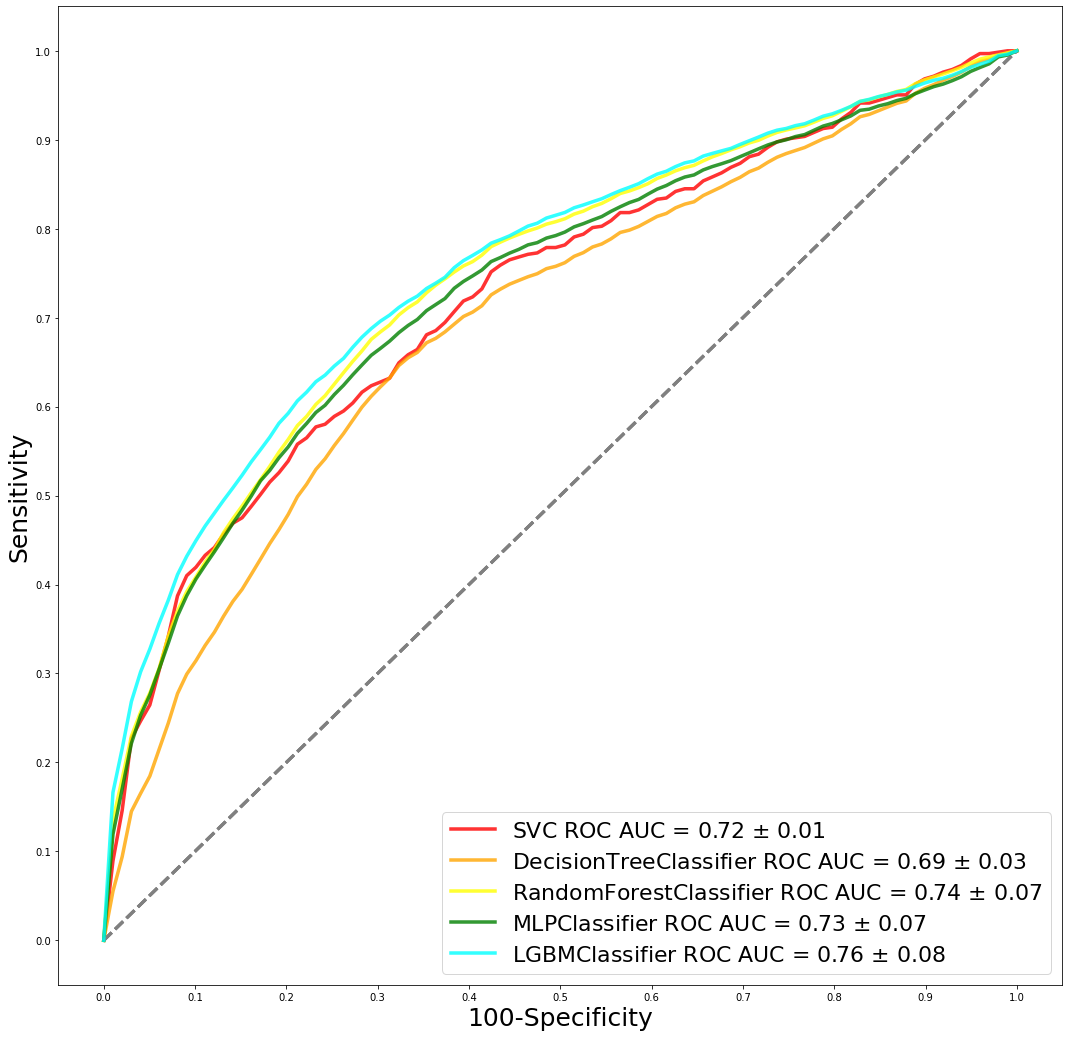

In [7]:
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        probas_ = model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_train.iloc[test])
     # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
     #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    parameters = {'xtick.labelsize': 22,
                  'ytick.labelsize': 22}
    plt.rcParams.update(parameters)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='gray',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=cs[c],label= model_name + r' ROC AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),lw=3.5, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    c +=1

# 相关的设置被注释掉，可以恢复并查看画图效果。
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
#plt.xlim([-0, 1])
#plt.ylim([-0, 1])
    plt.xlabel('100-Specificity', fontsize = 25)
    plt.ylabel('Sensitivity', fontsize = 25)
#plt.title('Receiver operating characteristic example', fontsize = 'x-large')
    plt.legend(loc="lower right" ,prop={"size":22})

plt.savefig('Train_ROC.pdf',dpi=300)
plt.show()


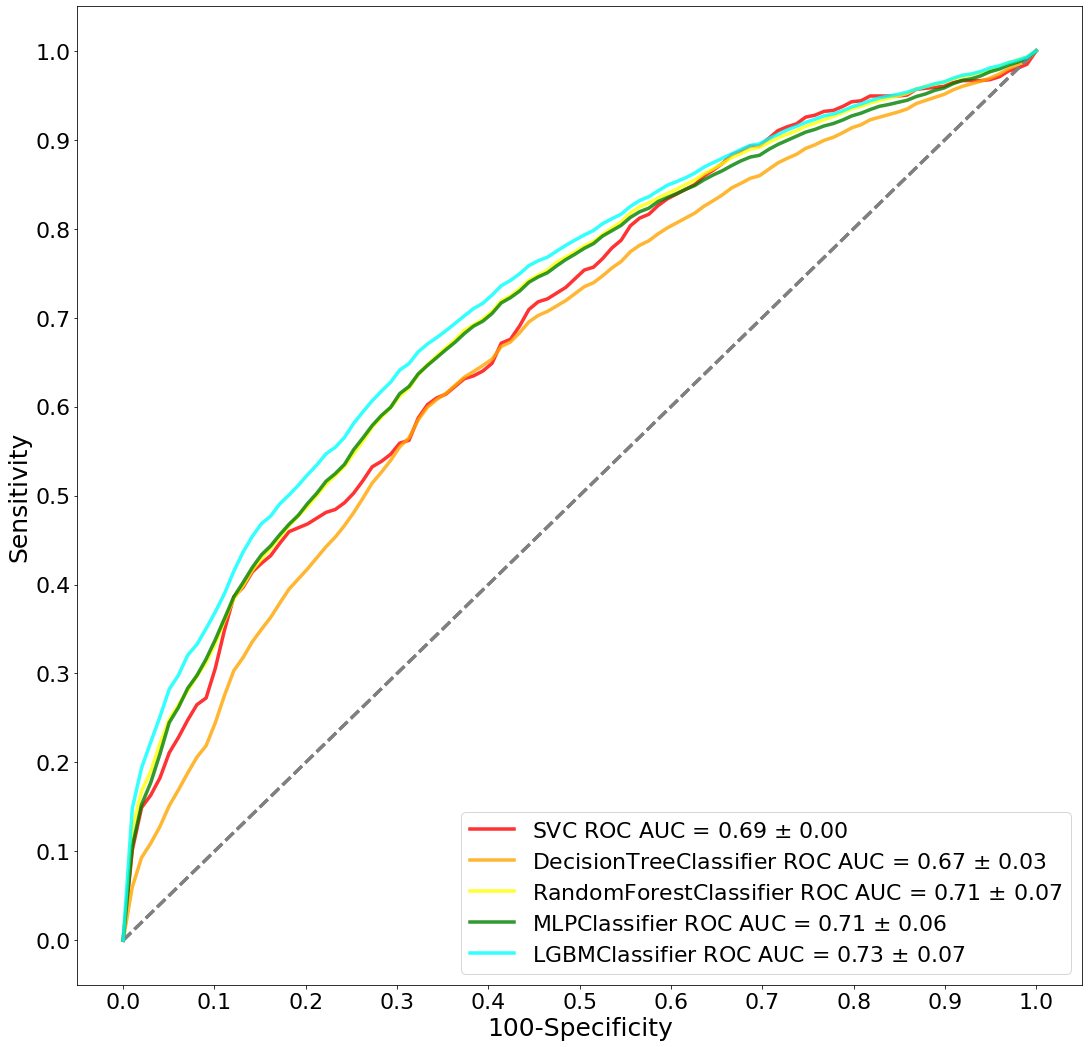

In [9]:
#test
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
lw=2
i = 0
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

cc = ClusterCentroids(random_state=0)
X_teresampled, y_teresampled = cc.fit_resample(x_test, y_test)
x_test = X_teresampled
y_test = y_teresampled
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        probas_= model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_test) #需要修改的是clf，即训练得到的model；以及测试集的X_test和y_test.
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1       
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='gray',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=cs[c],label= model_name + r' ROC AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),lw=3.5, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.xlabel('100-Specificity', fontsize = 25)
    plt.ylabel('Sensitivity', fontsize = 25)
        #plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right" ,prop={"size":22})
    c +=1

plt.savefig('Test_ROC.pdf',dpi=300)
plt.show()

# Test-optimization

# LGB

In [12]:
lgb_train = lgb.Dataset(x_train, y_train)
### 设置初始参数--不含交叉验证参数
print('设置参数')
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'nthread': 4,
    'learning_rate': 0.01,
    'verbose': -1
    # 'device': 'gpu'
}

### 交叉验证(调参)
print('交叉验证')
min_loss = float('1000')
best_params = {}

# 准确率
print("调参1：提高准确率")
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 8, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth

        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=1
        )
        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合

print("调参3：降低过拟合")
for feature_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0, 50, 5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                params,
                lgb_train,
                seed=1,
                nfold=10,
                metrics=['auc'],
                early_stopping_rounds=10,
                verbose_eval=-1
            )

            mean_loss = pd.Series(cv_results['auc-mean']).min()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

            if mean_loss <= min_loss:
                min_loss = mean_loss
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']
print("调参4：降低过拟合")
for lambda_l1 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    for lambda_l2 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.4, 0.6, 0.7, 0.9, 1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=-1
        )

        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    params['min_split_gain'] = min_split_gain

    cv_results = lgb.cv(
        params,
        lgb_train,
        seed=1,
        nfold=10,
        metrics=['auc'],
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    mean_auc = pd.Series(cv_results['auc-mean']).min()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

    if mean_loss <= min_loss:
        min_loss = mean_loss

        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']

print(best_params)

设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's auc: 0.770193 + 0.034636
[2]	cv_agg's auc: 0.770193 + 0.034636
[3]	cv_agg's auc: 0.770723 + 0.0349918
[4]	cv_agg's auc: 0.773104 + 0.0372727
[5]	cv_agg's auc: 0.773742 + 0.0364671
[6]	cv_agg's auc: 0.774869 + 0.0366417
[7]	cv_agg's auc: 0.777439 + 0.0339161
[8]	cv_agg's auc: 0.777737 + 0.033466
[9]	cv_agg's auc: 0.777439 + 0.033544
[10]	cv_agg's auc: 0.778497 + 0.0315541
[11]	cv_agg's auc: 0.77708 + 0.0325482
[12]	cv_agg's auc: 0.778083 + 0.0334601
[13]	cv_agg's auc: 0.780411 + 0.0328555
[14]	cv_agg's auc: 0.781785 + 0.0298892
[15]	cv_agg's auc: 0.785427 + 0.0292452
[16]	cv_agg's auc: 0.78568 + 0.0305836
[17]	cv_agg's auc: 0.788845 + 0.0288898
[18]	cv_agg's auc: 0.790521 + 0.0292268
[19]	cv_agg's auc: 0.791283 + 0.0277283
[20]	cv_agg's auc: 0.790677 + 0.0280709
[21]	cv_agg's auc: 0.790771 + 0.0285906
[22]	cv_agg's auc: 0.792538 + 0.0295932
[23]	cv_agg's auc: 0.792974 + 0.0296199
[24]	cv_agg's auc: 0.793578 + 0.0302764
[25]	cv_agg's auc: 0.794823 + 0.029

[100]	cv_agg's auc: 0.821898 + 0.0344185
[1]	cv_agg's auc: 0.764442 + 0.0397253
[2]	cv_agg's auc: 0.767448 + 0.0372056
[3]	cv_agg's auc: 0.767978 + 0.0375758
[4]	cv_agg's auc: 0.769349 + 0.0384969
[5]	cv_agg's auc: 0.770309 + 0.0391262
[6]	cv_agg's auc: 0.770422 + 0.0384574
[7]	cv_agg's auc: 0.77237 + 0.0406373
[8]	cv_agg's auc: 0.774812 + 0.0352629
[9]	cv_agg's auc: 0.77557 + 0.0366427
[10]	cv_agg's auc: 0.77537 + 0.0364603
[11]	cv_agg's auc: 0.774505 + 0.0367242
[12]	cv_agg's auc: 0.774686 + 0.0370921
[13]	cv_agg's auc: 0.775301 + 0.0379252
[14]	cv_agg's auc: 0.778228 + 0.0336606
[15]	cv_agg's auc: 0.782311 + 0.0343447
[16]	cv_agg's auc: 0.783559 + 0.0313212
[17]	cv_agg's auc: 0.786759 + 0.0290654
[18]	cv_agg's auc: 0.788003 + 0.0304289
[19]	cv_agg's auc: 0.788093 + 0.0308115
[20]	cv_agg's auc: 0.787559 + 0.031138
[21]	cv_agg's auc: 0.790467 + 0.0313774
[22]	cv_agg's auc: 0.792134 + 0.0308007
[23]	cv_agg's auc: 0.791863 + 0.0312554
[24]	cv_agg's auc: 0.792482 + 0.0318746
[25]	cv_agg'

[82]	cv_agg's auc: 0.818526 + 0.0329086
[83]	cv_agg's auc: 0.818783 + 0.0328202
[84]	cv_agg's auc: 0.819368 + 0.0329056
[85]	cv_agg's auc: 0.819169 + 0.0328287
[86]	cv_agg's auc: 0.818891 + 0.0332289
[87]	cv_agg's auc: 0.819302 + 0.0334263
[88]	cv_agg's auc: 0.819304 + 0.0337318
[89]	cv_agg's auc: 0.81951 + 0.0343185
[90]	cv_agg's auc: 0.819611 + 0.0342145
[91]	cv_agg's auc: 0.820278 + 0.033973
[92]	cv_agg's auc: 0.820385 + 0.0335592
[93]	cv_agg's auc: 0.820766 + 0.0340137
[94]	cv_agg's auc: 0.820992 + 0.03365
[95]	cv_agg's auc: 0.82105 + 0.0341251
[96]	cv_agg's auc: 0.821203 + 0.0341525
[97]	cv_agg's auc: 0.821407 + 0.0340798
[98]	cv_agg's auc: 0.821766 + 0.0340851
[99]	cv_agg's auc: 0.821509 + 0.0341144
[100]	cv_agg's auc: 0.821506 + 0.0342683
[1]	cv_agg's auc: 0.763828 + 0.0399713
[2]	cv_agg's auc: 0.765329 + 0.0384206
[3]	cv_agg's auc: 0.764434 + 0.0368532
[4]	cv_agg's auc: 0.76938 + 0.0396986
[5]	cv_agg's auc: 0.772124 + 0.0376416
[6]	cv_agg's auc: 0.769322 + 0.0374734
[7]	cv_agg'

[38]	cv_agg's auc: 0.803832 + 0.0436454
[39]	cv_agg's auc: 0.80421 + 0.0439663
[40]	cv_agg's auc: 0.805435 + 0.0436231
[41]	cv_agg's auc: 0.805339 + 0.0433431
[42]	cv_agg's auc: 0.804881 + 0.0437691
[43]	cv_agg's auc: 0.806268 + 0.0430087
[44]	cv_agg's auc: 0.807551 + 0.0420957
[45]	cv_agg's auc: 0.808162 + 0.0418191
[46]	cv_agg's auc: 0.809614 + 0.0411671
[47]	cv_agg's auc: 0.811242 + 0.0402928
[48]	cv_agg's auc: 0.811752 + 0.039874
[49]	cv_agg's auc: 0.812215 + 0.0398702
[50]	cv_agg's auc: 0.813516 + 0.0393633
[51]	cv_agg's auc: 0.814056 + 0.0390602
[52]	cv_agg's auc: 0.814054 + 0.0387505
[53]	cv_agg's auc: 0.813998 + 0.0387306
[54]	cv_agg's auc: 0.814353 + 0.0376114
[55]	cv_agg's auc: 0.814858 + 0.0377114
[56]	cv_agg's auc: 0.814957 + 0.0382104
[57]	cv_agg's auc: 0.814759 + 0.0384154
[58]	cv_agg's auc: 0.815163 + 0.037944
[59]	cv_agg's auc: 0.815825 + 0.0372636
[60]	cv_agg's auc: 0.815979 + 0.0372985
[61]	cv_agg's auc: 0.816729 + 0.0363299
[62]	cv_agg's auc: 0.81665 + 0.0360618
[63]

[8]	cv_agg's auc: 0.780137 + 0.0397258
[9]	cv_agg's auc: 0.780392 + 0.0399379
[10]	cv_agg's auc: 0.782974 + 0.0376707
[11]	cv_agg's auc: 0.784983 + 0.035984
[12]	cv_agg's auc: 0.785897 + 0.0377517
[13]	cv_agg's auc: 0.785975 + 0.038266
[14]	cv_agg's auc: 0.787603 + 0.0379585
[15]	cv_agg's auc: 0.78848 + 0.0392574
[16]	cv_agg's auc: 0.789264 + 0.0376281
[17]	cv_agg's auc: 0.790621 + 0.0397017
[18]	cv_agg's auc: 0.791187 + 0.0391962
[19]	cv_agg's auc: 0.793422 + 0.040523
[20]	cv_agg's auc: 0.793726 + 0.0397999
[21]	cv_agg's auc: 0.794329 + 0.0403998
[22]	cv_agg's auc: 0.796246 + 0.0400366
[23]	cv_agg's auc: 0.797029 + 0.0398246
[24]	cv_agg's auc: 0.798186 + 0.0388368
[25]	cv_agg's auc: 0.79896 + 0.0401002
[26]	cv_agg's auc: 0.799054 + 0.0393983
[27]	cv_agg's auc: 0.799541 + 0.0397285
[28]	cv_agg's auc: 0.801215 + 0.0389232
[29]	cv_agg's auc: 0.801886 + 0.0386811
[30]	cv_agg's auc: 0.802409 + 0.0387341
[31]	cv_agg's auc: 0.804071 + 0.0395469
[32]	cv_agg's auc: 0.80414 + 0.0392405
[33]	cv_

[20]	cv_agg's auc: 0.794079 + 0.0378638
[21]	cv_agg's auc: 0.795236 + 0.0372576
[22]	cv_agg's auc: 0.797769 + 0.0362101
[23]	cv_agg's auc: 0.799642 + 0.035479
[24]	cv_agg's auc: 0.801846 + 0.0353618
[25]	cv_agg's auc: 0.803005 + 0.0349697
[26]	cv_agg's auc: 0.803818 + 0.0369871
[27]	cv_agg's auc: 0.805601 + 0.036428
[28]	cv_agg's auc: 0.806929 + 0.0365102
[29]	cv_agg's auc: 0.807864 + 0.0363671
[30]	cv_agg's auc: 0.808999 + 0.0365377
[31]	cv_agg's auc: 0.810238 + 0.0373015
[32]	cv_agg's auc: 0.811516 + 0.037442
[33]	cv_agg's auc: 0.81253 + 0.0374427
[34]	cv_agg's auc: 0.81288 + 0.0373364
[35]	cv_agg's auc: 0.813738 + 0.0379938
[36]	cv_agg's auc: 0.814781 + 0.0392363
[37]	cv_agg's auc: 0.815437 + 0.0393289
[38]	cv_agg's auc: 0.8159 + 0.0401164
[39]	cv_agg's auc: 0.815846 + 0.0413797
[40]	cv_agg's auc: 0.816685 + 0.0412735
[41]	cv_agg's auc: 0.816163 + 0.0417885
[42]	cv_agg's auc: 0.815856 + 0.0409747
[43]	cv_agg's auc: 0.816444 + 0.041678
[44]	cv_agg's auc: 0.815859 + 0.0418179
[45]	cv_

[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc

[42]	cv_agg's auc: 0.820025 + 0.0407386
[43]	cv_agg's auc: 0.820684 + 0.0411297
[44]	cv_agg's auc: 0.821321 + 0.0410854
[45]	cv_agg's auc: 0.82209 + 0.0407812
[46]	cv_agg's auc: 0.822903 + 0.0418555
[47]	cv_agg's auc: 0.823621 + 0.0413989
[48]	cv_agg's auc: 0.823766 + 0.0410575
[49]	cv_agg's auc: 0.824624 + 0.0415771
[50]	cv_agg's auc: 0.824838 + 0.0415272
[51]	cv_agg's auc: 0.825094 + 0.0409103
[52]	cv_agg's auc: 0.825813 + 0.0408372
[53]	cv_agg's auc: 0.826263 + 0.0405139
[54]	cv_agg's auc: 0.826629 + 0.0401062
[55]	cv_agg's auc: 0.827804 + 0.0408726
[56]	cv_agg's auc: 0.828571 + 0.0407268
[57]	cv_agg's auc: 0.828668 + 0.0403743
[58]	cv_agg's auc: 0.828927 + 0.0406904
[59]	cv_agg's auc: 0.828986 + 0.0405558
[60]	cv_agg's auc: 0.828982 + 0.0406577
[61]	cv_agg's auc: 0.829237 + 0.0406976
[62]	cv_agg's auc: 0.828775 + 0.040987
[63]	cv_agg's auc: 0.829288 + 0.0409593
[64]	cv_agg's auc: 0.829843 + 0.0412897
[65]	cv_agg's auc: 0.829887 + 0.0411436
[66]	cv_agg's auc: 0.830196 + 0.0409008
[6

[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc

[37]	cv_agg's auc: 0.816415 + 0.0418046
[38]	cv_agg's auc: 0.817629 + 0.041754
[39]	cv_agg's auc: 0.817502 + 0.0418955
[40]	cv_agg's auc: 0.819372 + 0.0428128
[41]	cv_agg's auc: 0.819851 + 0.0432375
[42]	cv_agg's auc: 0.820161 + 0.0431987
[43]	cv_agg's auc: 0.820494 + 0.043558
[44]	cv_agg's auc: 0.82075 + 0.0431953
[45]	cv_agg's auc: 0.821161 + 0.0436255
[46]	cv_agg's auc: 0.821569 + 0.0435874
[47]	cv_agg's auc: 0.822386 + 0.0440429
[48]	cv_agg's auc: 0.822132 + 0.0430484
[49]	cv_agg's auc: 0.823101 + 0.0434307
[50]	cv_agg's auc: 0.822994 + 0.0441242
[51]	cv_agg's auc: 0.823296 + 0.0442838
[52]	cv_agg's auc: 0.823818 + 0.0442994
[53]	cv_agg's auc: 0.824328 + 0.044673
[54]	cv_agg's auc: 0.824987 + 0.0438507
[55]	cv_agg's auc: 0.82566 + 0.0439665
[56]	cv_agg's auc: 0.826021 + 0.0438593
[57]	cv_agg's auc: 0.826426 + 0.0438823
[58]	cv_agg's auc: 0.827044 + 0.0439564
[59]	cv_agg's auc: 0.828166 + 0.0437057
[60]	cv_agg's auc: 0.827912 + 0.0429541
[61]	cv_agg's auc: 0.828631 + 0.0425947
[62]	

[100]	cv_agg's auc: 0.821506 + 0.0342683
[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's a

[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_agg's auc: 0.812922 + 0.0429327
[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_agg's auc: 0.819496 + 0.0434284
[42]	cv_agg's auc: 0.820106 + 0.0434126
[43]	cv_agg's auc: 0.820237 + 0.0437024
[44]	cv_agg's auc: 0.821057 + 0.0431051
[45]	cv_agg's auc: 0.8208 + 0.0442372
[46]	cv_agg's auc: 0.821373 + 0.0434285
[47]	cv_agg's auc: 0.822186 + 0.0437641
[48]	cv_agg's auc: 0.822029 + 0.0434087
[49]	cv_agg's auc: 0.822747 + 0.043788
[50]	cv_agg's auc: 0.823251 + 0.044203
[51]	cv_agg's auc: 0.823044 + 0.0445353
[52]	cv_agg's auc: 0.823705 + 0.0448147
[53]	cv_agg's auc: 0.824321 + 0.0451949
[54]	cv_

[68]	cv_agg's auc: 0.816481 + 0.0349855
[69]	cv_agg's auc: 0.817199 + 0.0338187
[70]	cv_agg's auc: 0.816996 + 0.0342948
[71]	cv_agg's auc: 0.817047 + 0.0335416
[72]	cv_agg's auc: 0.817708 + 0.0336945
[73]	cv_agg's auc: 0.817477 + 0.0337168
[74]	cv_agg's auc: 0.817844 + 0.0336862
[75]	cv_agg's auc: 0.817739 + 0.0335655
[76]	cv_agg's auc: 0.81802 + 0.0330171
[77]	cv_agg's auc: 0.818164 + 0.0331935
[78]	cv_agg's auc: 0.818467 + 0.0331636
[79]	cv_agg's auc: 0.818571 + 0.0332493
[80]	cv_agg's auc: 0.818623 + 0.032818
[81]	cv_agg's auc: 0.818422 + 0.0335424
[82]	cv_agg's auc: 0.818526 + 0.0329086
[83]	cv_agg's auc: 0.818783 + 0.0328202
[84]	cv_agg's auc: 0.819368 + 0.0329056
[85]	cv_agg's auc: 0.819169 + 0.0328287
[86]	cv_agg's auc: 0.818891 + 0.0332289
[87]	cv_agg's auc: 0.819302 + 0.0334263
[88]	cv_agg's auc: 0.819304 + 0.0337318
[89]	cv_agg's auc: 0.81951 + 0.0343185
[90]	cv_agg's auc: 0.819611 + 0.0342145
[91]	cv_agg's auc: 0.820278 + 0.033973
[92]	cv_agg's auc: 0.820385 + 0.0335592
[93]

[9]	cv_agg's auc: 0.777644 + 0.0376299
[10]	cv_agg's auc: 0.780516 + 0.0383005
[11]	cv_agg's auc: 0.782938 + 0.0377799
[12]	cv_agg's auc: 0.785849 + 0.0397687
[13]	cv_agg's auc: 0.784699 + 0.0381383
[14]	cv_agg's auc: 0.785691 + 0.0404244
[15]	cv_agg's auc: 0.786666 + 0.0392233
[16]	cv_agg's auc: 0.786796 + 0.0390003
[17]	cv_agg's auc: 0.78815 + 0.037986
[18]	cv_agg's auc: 0.79025 + 0.0390237
[19]	cv_agg's auc: 0.790452 + 0.0385343
[20]	cv_agg's auc: 0.793737 + 0.0414025
[21]	cv_agg's auc: 0.794044 + 0.0410683
[22]	cv_agg's auc: 0.79425 + 0.042063
[23]	cv_agg's auc: 0.794875 + 0.0416766
[24]	cv_agg's auc: 0.797124 + 0.0415329
[25]	cv_agg's auc: 0.798959 + 0.0415653
[26]	cv_agg's auc: 0.801575 + 0.0410423
[27]	cv_agg's auc: 0.802824 + 0.041447
[28]	cv_agg's auc: 0.803998 + 0.0422321
[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_ag

[98]	cv_agg's auc: 0.821766 + 0.0340851
[99]	cv_agg's auc: 0.821509 + 0.0341144
[100]	cv_agg's auc: 0.821506 + 0.0342683
[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's a

[16]	cv_agg's auc: 0.786796 + 0.0390003
[17]	cv_agg's auc: 0.78815 + 0.037986
[18]	cv_agg's auc: 0.79025 + 0.0390237
[19]	cv_agg's auc: 0.790452 + 0.0385343
[20]	cv_agg's auc: 0.793737 + 0.0414025
[21]	cv_agg's auc: 0.794044 + 0.0410683
[22]	cv_agg's auc: 0.79425 + 0.042063
[23]	cv_agg's auc: 0.794875 + 0.0416766
[24]	cv_agg's auc: 0.797124 + 0.0415329
[25]	cv_agg's auc: 0.798959 + 0.0415653
[26]	cv_agg's auc: 0.801575 + 0.0410423
[27]	cv_agg's auc: 0.802824 + 0.041447
[28]	cv_agg's auc: 0.803998 + 0.0422321
[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_agg's auc: 0.812922 + 0.0429327
[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_ag

[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc

[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_agg's auc: 0.812922 + 0.0429327
[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_agg's auc: 0.819496 + 0.0434284
[42]	cv_agg's auc: 0.820106 + 0.0434126
[43]	cv_agg's auc: 0.820237 + 0.0437024
[44]	cv_agg's auc: 0.821057 + 0.0431051
[45]	cv_agg's auc: 0.8208 + 0.0442372
[46]	cv_agg's auc: 0.821373 + 0.0434285
[47]	cv_agg's auc: 0.822186 + 0.0437641
[48]	cv_agg's auc: 0.822029 + 0.0434087
[49]	cv_agg's auc: 0.822747 + 0.043788
[50]	cv_agg's auc: 0.823251 + 0.044203
[51]	cv_agg's auc: 0.823044 + 0.0445353
[52]	cv_agg's auc: 0.823705 + 0.0448147
[53]	cv_agg's auc: 0.824321 + 0.0451949
[54]	cv_agg's auc: 0.82453 + 0.0440045
[55]	cv_agg's auc: 0.825562 + 0.0444907
[56]	cv_agg's auc: 0.826121 + 0.0442201
[57]	c

[63]	cv_agg's auc: 0.825807 + 0.0408188
[64]	cv_agg's auc: 0.82566 + 0.040902
[65]	cv_agg's auc: 0.826369 + 0.0407501
[66]	cv_agg's auc: 0.827078 + 0.0405161
[67]	cv_agg's auc: 0.827386 + 0.040108
[68]	cv_agg's auc: 0.828047 + 0.0405528
[69]	cv_agg's auc: 0.827794 + 0.0403685
[70]	cv_agg's auc: 0.828142 + 0.0403849
[71]	cv_agg's auc: 0.829058 + 0.0407642
[72]	cv_agg's auc: 0.828859 + 0.0401425
[73]	cv_agg's auc: 0.828916 + 0.0397716
[74]	cv_agg's auc: 0.828854 + 0.0408892
[75]	cv_agg's auc: 0.828907 + 0.0405665
[76]	cv_agg's auc: 0.828753 + 0.0402371
[77]	cv_agg's auc: 0.828902 + 0.0405616
[78]	cv_agg's auc: 0.828652 + 0.039986
[79]	cv_agg's auc: 0.829615 + 0.0397689
[80]	cv_agg's auc: 0.82946 + 0.0399415
[81]	cv_agg's auc: 0.830178 + 0.0389222
[82]	cv_agg's auc: 0.83023 + 0.0387414
[83]	cv_agg's auc: 0.829619 + 0.0386988
[84]	cv_agg's auc: 0.829726 + 0.0388296
[85]	cv_agg's auc: 0.829523 + 0.0389543
[86]	cv_agg's auc: 0.829473 + 0.0388277
[87]	cv_agg's auc: 0.829476 + 0.0387878
[88]	c

[79]	cv_agg's auc: 0.83427 + 0.0408198
[80]	cv_agg's auc: 0.834421 + 0.0402377
[81]	cv_agg's auc: 0.835134 + 0.0396026
[82]	cv_agg's auc: 0.835395 + 0.0388823
[83]	cv_agg's auc: 0.835545 + 0.0386635
[84]	cv_agg's auc: 0.835903 + 0.0385686
[85]	cv_agg's auc: 0.836518 + 0.0384045
[86]	cv_agg's auc: 0.836158 + 0.0383883
[87]	cv_agg's auc: 0.836003 + 0.0386298
[88]	cv_agg's auc: 0.836207 + 0.0380746
[89]	cv_agg's auc: 0.836619 + 0.0384522
[90]	cv_agg's auc: 0.837134 + 0.037993
[91]	cv_agg's auc: 0.837487 + 0.0382123
[92]	cv_agg's auc: 0.837487 + 0.0383065
[93]	cv_agg's auc: 0.837436 + 0.0376746
[94]	cv_agg's auc: 0.837434 + 0.0377999
[95]	cv_agg's auc: 0.837281 + 0.03782
[96]	cv_agg's auc: 0.837123 + 0.038272
[97]	cv_agg's auc: 0.837174 + 0.0380687
[98]	cv_agg's auc: 0.837231 + 0.0376532
[99]	cv_agg's auc: 0.837638 + 0.037914
[100]	cv_agg's auc: 0.837186 + 0.0379155
[1]	cv_agg's auc: 0.773485 + 0.04196
[2]	cv_agg's auc: 0.773795 + 0.0417888
[3]	cv_agg's auc: 0.774636 + 0.0433968
[4]	cv_agg

[21]	cv_agg's auc: 0.798478 + 0.0368408
[22]	cv_agg's auc: 0.799294 + 0.0367228
[23]	cv_agg's auc: 0.801805 + 0.0366537
[24]	cv_agg's auc: 0.803478 + 0.0383919
[25]	cv_agg's auc: 0.805367 + 0.0379921
[26]	cv_agg's auc: 0.806945 + 0.0381825
[27]	cv_agg's auc: 0.807712 + 0.0386473
[28]	cv_agg's auc: 0.808296 + 0.0380941
[29]	cv_agg's auc: 0.809814 + 0.0378781
[30]	cv_agg's auc: 0.810073 + 0.0385166
[31]	cv_agg's auc: 0.811371 + 0.039496
[32]	cv_agg's auc: 0.81176 + 0.039619
[33]	cv_agg's auc: 0.812533 + 0.0388194
[34]	cv_agg's auc: 0.813626 + 0.0384622
[35]	cv_agg's auc: 0.814753 + 0.0382969
[36]	cv_agg's auc: 0.814741 + 0.0380303
[37]	cv_agg's auc: 0.813731 + 0.0388519
[38]	cv_agg's auc: 0.814564 + 0.0395573
[39]	cv_agg's auc: 0.815364 + 0.039714
[40]	cv_agg's auc: 0.815852 + 0.0401152
[41]	cv_agg's auc: 0.815857 + 0.0396952
[42]	cv_agg's auc: 0.816877 + 0.0400053
[43]	cv_agg's auc: 0.817026 + 0.0406933
[44]	cv_agg's auc: 0.817692 + 0.0410364
[45]	cv_agg's auc: 0.818104 + 0.0411487
[46]

[30]	cv_agg's auc: 0.807264 + 0.0394897
[31]	cv_agg's auc: 0.807655 + 0.038967
[32]	cv_agg's auc: 0.810459 + 0.0392708
[33]	cv_agg's auc: 0.811773 + 0.0405722
[34]	cv_agg's auc: 0.812713 + 0.0402363
[35]	cv_agg's auc: 0.813598 + 0.0412251
[36]	cv_agg's auc: 0.814711 + 0.0407963
[37]	cv_agg's auc: 0.815506 + 0.0398842
[38]	cv_agg's auc: 0.817138 + 0.0398438
[39]	cv_agg's auc: 0.818562 + 0.0397629
[40]	cv_agg's auc: 0.819025 + 0.0404947
[41]	cv_agg's auc: 0.81947 + 0.0405217
[42]	cv_agg's auc: 0.820437 + 0.0415115
[43]	cv_agg's auc: 0.820186 + 0.0411583
[44]	cv_agg's auc: 0.819946 + 0.0416786
[45]	cv_agg's auc: 0.821128 + 0.0410638
[46]	cv_agg's auc: 0.822089 + 0.0414777
[47]	cv_agg's auc: 0.821891 + 0.0413418
[48]	cv_agg's auc: 0.822711 + 0.0419244
[49]	cv_agg's auc: 0.823278 + 0.042212
[50]	cv_agg's auc: 0.823995 + 0.0423513
[51]	cv_agg's auc: 0.824143 + 0.0423584
[52]	cv_agg's auc: 0.825218 + 0.0416594
[53]	cv_agg's auc: 0.825524 + 0.0415425
[54]	cv_agg's auc: 0.825881 + 0.0421883
[55

[52]	cv_agg's auc: 0.815764 + 0.0424424
[53]	cv_agg's auc: 0.815871 + 0.0425297
[54]	cv_agg's auc: 0.816248 + 0.0424022
[55]	cv_agg's auc: 0.816915 + 0.0422098
[56]	cv_agg's auc: 0.817524 + 0.0417012
[57]	cv_agg's auc: 0.817934 + 0.0416035
[58]	cv_agg's auc: 0.817881 + 0.0410094
[59]	cv_agg's auc: 0.81916 + 0.0408204
[60]	cv_agg's auc: 0.818757 + 0.0408906
[61]	cv_agg's auc: 0.819021 + 0.0409288
[62]	cv_agg's auc: 0.819627 + 0.0408516
[63]	cv_agg's auc: 0.820526 + 0.0403452
[64]	cv_agg's auc: 0.820786 + 0.0396244
[65]	cv_agg's auc: 0.820997 + 0.0390525
[66]	cv_agg's auc: 0.821094 + 0.0394829
[67]	cv_agg's auc: 0.821553 + 0.0389189
[68]	cv_agg's auc: 0.821502 + 0.0391358
[69]	cv_agg's auc: 0.82181 + 0.0386148
[70]	cv_agg's auc: 0.821735 + 0.0383464
[71]	cv_agg's auc: 0.821691 + 0.037351
[72]	cv_agg's auc: 0.821947 + 0.0378576
[73]	cv_agg's auc: 0.822199 + 0.0374858
[74]	cv_agg's auc: 0.822755 + 0.0377952
[75]	cv_agg's auc: 0.822322 + 0.0373719
[76]	cv_agg's auc: 0.82258 + 0.0367678
[77]

[72]	cv_agg's auc: 0.832588 + 0.040855
[73]	cv_agg's auc: 0.833104 + 0.0405011
[74]	cv_agg's auc: 0.832485 + 0.0407232
[75]	cv_agg's auc: 0.833458 + 0.039951
[76]	cv_agg's auc: 0.834024 + 0.0404203
[77]	cv_agg's auc: 0.833867 + 0.0409021
[78]	cv_agg's auc: 0.834123 + 0.0406131
[79]	cv_agg's auc: 0.833206 + 0.0405825
[80]	cv_agg's auc: 0.833515 + 0.0410002
[81]	cv_agg's auc: 0.833767 + 0.0405618
[82]	cv_agg's auc: 0.833154 + 0.0411214
[83]	cv_agg's auc: 0.833563 + 0.0412922
[84]	cv_agg's auc: 0.83372 + 0.0415498
[85]	cv_agg's auc: 0.833973 + 0.0409275
[86]	cv_agg's auc: 0.834279 + 0.0404513
[87]	cv_agg's auc: 0.833872 + 0.040546
[88]	cv_agg's auc: 0.834437 + 0.0399114
[89]	cv_agg's auc: 0.834585 + 0.040255
[90]	cv_agg's auc: 0.834486 + 0.0399269
[91]	cv_agg's auc: 0.834379 + 0.04058
[92]	cv_agg's auc: 0.834327 + 0.0407433
[93]	cv_agg's auc: 0.834327 + 0.0411858
[94]	cv_agg's auc: 0.834589 + 0.0408561
[95]	cv_agg's auc: 0.834685 + 0.0415504
[96]	cv_agg's auc: 0.834889 + 0.0417977
[97]	cv

[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc: 0.799129 + 0.0394308
[27]	cv_agg's auc: 0.800099 + 0.0396989
[28]	cv_agg's auc: 0.801317 + 0.0387431
[29]	cv_agg's auc: 0.801914 + 0.0383772
[30]	cv_agg's auc: 0.802639 + 0.0385707
[31]	cv_agg's auc: 0.804679 + 0.0395887
[32]	cv_agg's auc: 0.804445 + 0.039296
[33]	cv_agg's auc: 0.805861 + 0.0398455
[34]	cv_agg's auc: 0.806318 + 0.0394381
[35]	cv_agg's auc: 0.807171 + 0.0391991
[36]	cv_agg's auc: 0.807124 + 0.0398269
[37]	cv_agg's auc: 0.808069 + 0.0393933
[38]	cv_agg's auc: 0.808374 + 0.0398608
[39]	cv_agg's auc: 0.808654 + 0.0402328
[40]	cv_agg's auc: 0.809164 + 0.0412966
[41]	cv_agg's auc: 0.81019 + 0.0408897
[42]	cv_agg's auc: 0.810521 + 0.040891
[43]	cv_agg's auc: 0.810086 + 0.0405465
[44]	cv_agg's auc: 0.810871 + 0.0410725
[45]	cv_agg's auc: 0.810967 + 0.041233
[46]	cv_agg's auc: 0.81189 + 0.0410569
[47]	cv_agg's auc: 0.812147 + 0.0422505
[48]	c

[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_agg's auc: 0.819496 + 0.0434284
[42]	cv_agg's auc: 0.820106 + 0.0434126
[43]	cv_agg's auc: 0.820237 + 0.0437024
[44]	cv_agg's auc: 0.821057 + 0.0431051
[45]	cv_agg's auc: 0.8208 + 0.0442372
[46]	cv_agg's auc: 0.821373 + 0.0434285
[47]	cv_agg's auc: 0.822186 + 0.0437641
[48]	cv_agg's auc: 0.822029 + 0.0434087
[49]	cv_agg's auc: 0.822747 + 0.043788
[50]	cv_agg's auc: 0.823251 + 0.044203
[51]	cv_agg's auc: 0.823044 + 0.0445353
[52]	cv_agg's auc: 0.823705 + 0.0448147
[53]	cv_agg's auc: 0.824321 + 0.0451949
[54]	cv_agg's auc: 0.82453 + 0.0440045
[55]	cv_agg's auc: 0.825562 + 0.0444907
[56]	cv_agg's auc: 0.826121 + 0.0442201
[57]	cv_agg's auc: 0.826681 + 0.0435284
[58]	cv_agg's auc: 0.82735 + 0.0433358
[59]	cv_agg's auc: 0.828879 + 0.0435408
[60]	cv

[56]	cv_agg's auc: 0.813055 + 0.0366374
[57]	cv_agg's auc: 0.813151 + 0.0363033
[58]	cv_agg's auc: 0.81315 + 0.0361494
[59]	cv_agg's auc: 0.813665 + 0.0354992
[60]	cv_agg's auc: 0.814144 + 0.035206
[61]	cv_agg's auc: 0.813745 + 0.0348342
[62]	cv_agg's auc: 0.814754 + 0.0348151
[63]	cv_agg's auc: 0.8152 + 0.0343555
[64]	cv_agg's auc: 0.816141 + 0.0347007
[65]	cv_agg's auc: 0.816428 + 0.0340537
[66]	cv_agg's auc: 0.816023 + 0.0346615
[67]	cv_agg's auc: 0.816179 + 0.0342337
[68]	cv_agg's auc: 0.816481 + 0.0349855
[69]	cv_agg's auc: 0.817199 + 0.0338187
[70]	cv_agg's auc: 0.816996 + 0.0342948
[71]	cv_agg's auc: 0.817047 + 0.0335416
[72]	cv_agg's auc: 0.817708 + 0.0336945
[73]	cv_agg's auc: 0.817477 + 0.0337168
[74]	cv_agg's auc: 0.817844 + 0.0336862
[75]	cv_agg's auc: 0.817739 + 0.0335655
[76]	cv_agg's auc: 0.81802 + 0.0330171
[77]	cv_agg's auc: 0.818164 + 0.0331935
[78]	cv_agg's auc: 0.818467 + 0.0331636
[79]	cv_agg's auc: 0.818571 + 0.0332493
[80]	cv_agg's auc: 0.818623 + 0.032818
[81]	c

[85]	cv_agg's auc: 0.829523 + 0.0389543
[86]	cv_agg's auc: 0.829473 + 0.0388277
[87]	cv_agg's auc: 0.829476 + 0.0387878
[88]	cv_agg's auc: 0.829837 + 0.0384882
[89]	cv_agg's auc: 0.829988 + 0.0379831
[90]	cv_agg's auc: 0.830546 + 0.0383441
[91]	cv_agg's auc: 0.830955 + 0.0377432
[92]	cv_agg's auc: 0.830955 + 0.0380401
[93]	cv_agg's auc: 0.831567 + 0.0376583
[94]	cv_agg's auc: 0.831413 + 0.0379501
[95]	cv_agg's auc: 0.83131 + 0.0380667
[96]	cv_agg's auc: 0.831209 + 0.0386811
[97]	cv_agg's auc: 0.831568 + 0.0384532
[98]	cv_agg's auc: 0.83172 + 0.0384688
[99]	cv_agg's auc: 0.831882 + 0.0379494
[100]	cv_agg's auc: 0.831573 + 0.037891
[1]	cv_agg's auc: 0.760622 + 0.0430741
[2]	cv_agg's auc: 0.761513 + 0.040405
[3]	cv_agg's auc: 0.764422 + 0.0395499
[4]	cv_agg's auc: 0.766707 + 0.0403093
[5]	cv_agg's auc: 0.771608 + 0.0372739
[6]	cv_agg's auc: 0.771961 + 0.036851
[7]	cv_agg's auc: 0.777561 + 0.0373512
[8]	cv_agg's auc: 0.779177 + 0.0347664
[9]	cv_agg's auc: 0.777644 + 0.0376299
[10]	cv_agg's

[1]	cv_agg's auc: 0.773485 + 0.04196
[2]	cv_agg's auc: 0.773795 + 0.0417888
[3]	cv_agg's auc: 0.774636 + 0.0433968
[4]	cv_agg's auc: 0.779163 + 0.0418413
[5]	cv_agg's auc: 0.778953 + 0.0407163
[6]	cv_agg's auc: 0.779153 + 0.0380944
[7]	cv_agg's auc: 0.780683 + 0.0391598
[8]	cv_agg's auc: 0.783067 + 0.0388418
[9]	cv_agg's auc: 0.785505 + 0.0353431
[10]	cv_agg's auc: 0.786518 + 0.0343444
[11]	cv_agg's auc: 0.787472 + 0.0344039
[12]	cv_agg's auc: 0.786893 + 0.0337167
[13]	cv_agg's auc: 0.788087 + 0.0334925
[14]	cv_agg's auc: 0.788094 + 0.0333732
[15]	cv_agg's auc: 0.788099 + 0.0325679
[16]	cv_agg's auc: 0.790876 + 0.0355422
[17]	cv_agg's auc: 0.791177 + 0.0337751
[18]	cv_agg's auc: 0.794148 + 0.033814
[19]	cv_agg's auc: 0.795265 + 0.0333377
[20]	cv_agg's auc: 0.795601 + 0.0331872
[21]	cv_agg's auc: 0.794626 + 0.0342009
[22]	cv_agg's auc: 0.795288 + 0.0349685
[23]	cv_agg's auc: 0.796163 + 0.0351079
[24]	cv_agg's auc: 0.79842 + 0.0348396
[25]	cv_agg's auc: 0.797761 + 0.0338525
[26]	cv_agg's

[15]	cv_agg's auc: 0.791918 + 0.0330878
[16]	cv_agg's auc: 0.794054 + 0.0322536
[17]	cv_agg's auc: 0.793978 + 0.0328491
[18]	cv_agg's auc: 0.795361 + 0.0348976
[19]	cv_agg's auc: 0.797045 + 0.0346981
[20]	cv_agg's auc: 0.797882 + 0.0358833
[21]	cv_agg's auc: 0.798478 + 0.0368408
[22]	cv_agg's auc: 0.799294 + 0.0367228
[23]	cv_agg's auc: 0.801805 + 0.0366537
[24]	cv_agg's auc: 0.803478 + 0.0383919
[25]	cv_agg's auc: 0.805367 + 0.0379921
[26]	cv_agg's auc: 0.806945 + 0.0381825
[27]	cv_agg's auc: 0.807712 + 0.0386473
[28]	cv_agg's auc: 0.808296 + 0.0380941
[29]	cv_agg's auc: 0.809814 + 0.0378781
[30]	cv_agg's auc: 0.810073 + 0.0385166
[31]	cv_agg's auc: 0.811371 + 0.039496
[32]	cv_agg's auc: 0.81176 + 0.039619
[33]	cv_agg's auc: 0.812533 + 0.0388194
[34]	cv_agg's auc: 0.813626 + 0.0384622
[35]	cv_agg's auc: 0.814753 + 0.0382969
[36]	cv_agg's auc: 0.814741 + 0.0380303
[37]	cv_agg's auc: 0.813731 + 0.0388519
[38]	cv_agg's auc: 0.814564 + 0.0395573
[39]	cv_agg's auc: 0.815364 + 0.039714
[40]

[30]	cv_agg's auc: 0.807264 + 0.0394897
[31]	cv_agg's auc: 0.807655 + 0.038967
[32]	cv_agg's auc: 0.810459 + 0.0392708
[33]	cv_agg's auc: 0.811773 + 0.0405722
[34]	cv_agg's auc: 0.812713 + 0.0402363
[35]	cv_agg's auc: 0.813598 + 0.0412251
[36]	cv_agg's auc: 0.814711 + 0.0407963
[37]	cv_agg's auc: 0.815506 + 0.0398842
[38]	cv_agg's auc: 0.817138 + 0.0398438
[39]	cv_agg's auc: 0.818562 + 0.0397629
[40]	cv_agg's auc: 0.819025 + 0.0404947
[41]	cv_agg's auc: 0.81947 + 0.0405217
[42]	cv_agg's auc: 0.820437 + 0.0415115
[43]	cv_agg's auc: 0.820186 + 0.0411583
[44]	cv_agg's auc: 0.819946 + 0.0416786
[45]	cv_agg's auc: 0.821128 + 0.0410638
[46]	cv_agg's auc: 0.822089 + 0.0414777
[47]	cv_agg's auc: 0.821891 + 0.0413418
[48]	cv_agg's auc: 0.822711 + 0.0419244
[49]	cv_agg's auc: 0.823278 + 0.042212
[50]	cv_agg's auc: 0.823995 + 0.0423513
[51]	cv_agg's auc: 0.824143 + 0.0423584
[52]	cv_agg's auc: 0.825218 + 0.0416594
[53]	cv_agg's auc: 0.825524 + 0.0415425
[54]	cv_agg's auc: 0.825881 + 0.0421883
[55

[52]	cv_agg's auc: 0.815764 + 0.0424424
[53]	cv_agg's auc: 0.815871 + 0.0425297
[54]	cv_agg's auc: 0.816248 + 0.0424022
[55]	cv_agg's auc: 0.816915 + 0.0422098
[56]	cv_agg's auc: 0.817524 + 0.0417012
[57]	cv_agg's auc: 0.817934 + 0.0416035
[58]	cv_agg's auc: 0.817881 + 0.0410094
[59]	cv_agg's auc: 0.81916 + 0.0408204
[60]	cv_agg's auc: 0.818757 + 0.0408906
[61]	cv_agg's auc: 0.819021 + 0.0409288
[62]	cv_agg's auc: 0.819627 + 0.0408516
[63]	cv_agg's auc: 0.820526 + 0.0403452
[64]	cv_agg's auc: 0.820786 + 0.0396244
[65]	cv_agg's auc: 0.820997 + 0.0390525
[66]	cv_agg's auc: 0.821094 + 0.0394829
[67]	cv_agg's auc: 0.821553 + 0.0389189
[68]	cv_agg's auc: 0.821502 + 0.0391358
[69]	cv_agg's auc: 0.82181 + 0.0386148
[70]	cv_agg's auc: 0.821735 + 0.0383464
[71]	cv_agg's auc: 0.821691 + 0.037351
[72]	cv_agg's auc: 0.821947 + 0.0378576
[73]	cv_agg's auc: 0.822199 + 0.0374858
[74]	cv_agg's auc: 0.822755 + 0.0377952
[75]	cv_agg's auc: 0.822322 + 0.0373719
[76]	cv_agg's auc: 0.82258 + 0.0367678
[77]

[71]	cv_agg's auc: 0.832131 + 0.0407487
[72]	cv_agg's auc: 0.832588 + 0.040855
[73]	cv_agg's auc: 0.833104 + 0.0405011
[74]	cv_agg's auc: 0.832485 + 0.0407232
[75]	cv_agg's auc: 0.833458 + 0.039951
[76]	cv_agg's auc: 0.834024 + 0.0404203
[77]	cv_agg's auc: 0.833867 + 0.0409021
[78]	cv_agg's auc: 0.834123 + 0.0406131
[79]	cv_agg's auc: 0.833206 + 0.0405825
[80]	cv_agg's auc: 0.833515 + 0.0410002
[81]	cv_agg's auc: 0.833767 + 0.0405618
[82]	cv_agg's auc: 0.833154 + 0.0411214
[83]	cv_agg's auc: 0.833563 + 0.0412922
[84]	cv_agg's auc: 0.83372 + 0.0415498
[85]	cv_agg's auc: 0.833973 + 0.0409275
[86]	cv_agg's auc: 0.834279 + 0.0404513
[87]	cv_agg's auc: 0.833872 + 0.040546
[88]	cv_agg's auc: 0.834437 + 0.0399114
[89]	cv_agg's auc: 0.834585 + 0.040255
[90]	cv_agg's auc: 0.834486 + 0.0399269
[91]	cv_agg's auc: 0.834379 + 0.04058
[92]	cv_agg's auc: 0.834327 + 0.0407433
[93]	cv_agg's auc: 0.834327 + 0.0411858
[94]	cv_agg's auc: 0.834589 + 0.0408561
[95]	cv_agg's auc: 0.834685 + 0.0415504
[96]	cv

[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc: 0.799129 + 0.0394308
[27]	cv_agg's auc: 0.800099 + 0.0396989
[28]	cv_agg's auc: 0.801317 + 0.0387431
[29]	cv_agg's auc: 0.801914 + 0.0383772
[30]	cv_agg's auc: 0.802639 + 0.0385707
[31]	cv_agg's auc: 0.804679 + 0.0395887
[32]	cv_agg's auc: 0.804445 + 0.039296
[33]	cv_agg's auc: 0.805861 + 0.0398455
[34]	cv_agg's auc: 0.806318 + 0.0394381
[35]	

[26]	cv_agg's auc: 0.801575 + 0.0410423
[27]	cv_agg's auc: 0.802824 + 0.041447
[28]	cv_agg's auc: 0.803998 + 0.0422321
[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_agg's auc: 0.812922 + 0.0429327
[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_agg's auc: 0.819496 + 0.0434284
[42]	cv_agg's auc: 0.820106 + 0.0434126
[43]	cv_agg's auc: 0.820237 + 0.0437024
[44]	cv_agg's auc: 0.821057 + 0.0431051
[45]	cv_agg's auc: 0.8208 + 0.0442372
[46]	cv_agg's auc: 0.821373 + 0.0434285
[47]	cv_agg's auc: 0.822186 + 0.0437641
[48]	cv_agg's auc: 0.822029 + 0.0434087
[49]	cv_agg's auc: 0.822747 + 0.043788
[50]	cv_agg's auc: 0.823251 + 0.044203
[51]	cv_a

[99]	cv_agg's auc: 0.821509 + 0.0341144
[100]	cv_agg's auc: 0.821506 + 0.0342683
[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's a

[23]	cv_agg's auc: 0.794875 + 0.0416766
[24]	cv_agg's auc: 0.797124 + 0.0415329
[25]	cv_agg's auc: 0.798959 + 0.0415653
[26]	cv_agg's auc: 0.801575 + 0.0410423
[27]	cv_agg's auc: 0.802824 + 0.041447
[28]	cv_agg's auc: 0.803998 + 0.0422321
[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg's auc: 0.811954 + 0.0418756
[34]	cv_agg's auc: 0.812922 + 0.0429327
[35]	cv_agg's auc: 0.814422 + 0.0428727
[36]	cv_agg's auc: 0.814326 + 0.0423578
[37]	cv_agg's auc: 0.816261 + 0.0419931
[38]	cv_agg's auc: 0.817729 + 0.0418742
[39]	cv_agg's auc: 0.817803 + 0.0420663
[40]	cv_agg's auc: 0.81912 + 0.0428484
[41]	cv_agg's auc: 0.819496 + 0.0434284
[42]	cv_agg's auc: 0.820106 + 0.0434126
[43]	cv_agg's auc: 0.820237 + 0.0437024
[44]	cv_agg's auc: 0.821057 + 0.0431051
[45]	cv_agg's auc: 0.8208 + 0.0442372
[46]	cv_agg's auc: 0.821373 + 0.0434285
[47]	cv_agg's auc: 0.822186 + 0.0437641
[48]	cv

[1]	cv_agg's auc: 0.758801 + 0.044208
[2]	cv_agg's auc: 0.764742 + 0.0398957
[3]	cv_agg's auc: 0.765371 + 0.0429206
[4]	cv_agg's auc: 0.772523 + 0.0437739
[5]	cv_agg's auc: 0.77281 + 0.041869
[6]	cv_agg's auc: 0.772676 + 0.041955
[7]	cv_agg's auc: 0.778234 + 0.0395244
[8]	cv_agg's auc: 0.779554 + 0.0395481
[9]	cv_agg's auc: 0.779985 + 0.0399979
[10]	cv_agg's auc: 0.783704 + 0.0376145
[11]	cv_agg's auc: 0.784501 + 0.036113
[12]	cv_agg's auc: 0.785591 + 0.0380012
[13]	cv_agg's auc: 0.785973 + 0.0387083
[14]	cv_agg's auc: 0.788813 + 0.0385939
[15]	cv_agg's auc: 0.788579 + 0.0396479
[16]	cv_agg's auc: 0.78901 + 0.0377771
[17]	cv_agg's auc: 0.791023 + 0.0401269
[18]	cv_agg's auc: 0.790832 + 0.0393189
[19]	cv_agg's auc: 0.793268 + 0.0404154
[20]	cv_agg's auc: 0.793522 + 0.0397716
[21]	cv_agg's auc: 0.79463 + 0.0405898
[22]	cv_agg's auc: 0.796395 + 0.0401523
[23]	cv_agg's auc: 0.796875 + 0.0398672
[24]	cv_agg's auc: 0.797879 + 0.0390336
[25]	cv_agg's auc: 0.79906 + 0.0402479
[26]	cv_agg's auc

[8]	cv_agg's auc: 0.779177 + 0.0347664
[9]	cv_agg's auc: 0.777644 + 0.0376299
[10]	cv_agg's auc: 0.780516 + 0.0383005
[11]	cv_agg's auc: 0.782938 + 0.0377799
[12]	cv_agg's auc: 0.785849 + 0.0397687
[13]	cv_agg's auc: 0.784699 + 0.0381383
[14]	cv_agg's auc: 0.785691 + 0.0404244
[15]	cv_agg's auc: 0.786666 + 0.0392233
[16]	cv_agg's auc: 0.786796 + 0.0390003
[17]	cv_agg's auc: 0.78815 + 0.037986
[18]	cv_agg's auc: 0.79025 + 0.0390237
[19]	cv_agg's auc: 0.790452 + 0.0385343
[20]	cv_agg's auc: 0.793737 + 0.0414025
[21]	cv_agg's auc: 0.794044 + 0.0410683
[22]	cv_agg's auc: 0.79425 + 0.042063
[23]	cv_agg's auc: 0.794875 + 0.0416766
[24]	cv_agg's auc: 0.797124 + 0.0415329
[25]	cv_agg's auc: 0.798959 + 0.0415653
[26]	cv_agg's auc: 0.801575 + 0.0410423
[27]	cv_agg's auc: 0.802824 + 0.041447
[28]	cv_agg's auc: 0.803998 + 0.0422321
[29]	cv_agg's auc: 0.806668 + 0.0418751
[30]	cv_agg's auc: 0.80787 + 0.042029
[31]	cv_agg's auc: 0.809445 + 0.041699
[32]	cv_agg's auc: 0.810588 + 0.0414507
[33]	cv_agg

In [20]:
#the best para:
#whole icu:
#{'num_leaves': 95, 'max_depth': 7, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 45, 'lambda_l1': 0.3, 'lambda_l2': 0.1}

def culatescore(predict, real):
    f1 = f1_score(real, predict, average='macro')
    scores.append(f1)
    return scores


del_feature = ['label']
features = [i for i in x_train.columns if i not in del_feature]

num_round = 5000

params = {'num_leaves': 95,
         # 'min_data_in_leaf': 61,
          'objective': 'binary',
          'max_depth': 7,
          'max_bin': 255,
          'learning_rate': 0.01,
         # "min_sum_hessian_in_leaf": 6,
          'min_split_gain': 1.0,
          "boosting": "gbdt",
          "feature_fraction": 0.9,
          "bagging_freq": 45,
          "bagging_fraction": 0.9,
          "bagging_seed": 11,
          "lambda_l1": 0.3,
          'lambda_l2': 0.1,
          "nthread": 4,
          'metric': 'auc',
          'silent': True,
          "random_state": 2022
          }
results = []
bigtestresults = []
smalltestresults = []
scores = []
folds = KFold(n_splits=10, shuffle=True, random_state=2021)
val_ac = 0
feature_importance_df = pd.DataFrame()
valid_tprs = []
train_tprs=[]
test_tprs=[]
aucs = []
mean_fpr = np.linspace(0, 1, 100)
r = 0

train_pre_lists=[]
train_y_lists=[]
test_pre_lists=[]
test_y_lists=[]

train_precisions = []
test_precisions = []
pr_aucs = []
mean_recall = np.linspace(0, 1, 100)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print("fold {}".format(fold_ + 1))
    train_x, train_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    valid_x, valid_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    trn_data = lgb.Dataset(train_x, label=train_y, silent=True)
    val_data = lgb.Dataset(x_test, label=y_test, silent=True)

    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=500)

    valid_pred = clf.predict(valid_x, num_iteration=clf.best_iteration)
    test_pre = clf.predict(x_test, num_iteration=clf.best_iteration)
    train_pre=clf.predict(train_x,num_iteration=clf.best_iteration)
    explainer = shap.TreeExplainer(clf,num_iteration=clf.best_iteration)
    shap_values = explainer.shap_values(train_x)
    
    threshold = 0.425
    smalltestresults = []
    for w in test_pre:
        temp = 1 if w > threshold else 0
        smalltestresults.append(temp)
    bigtestresults.append(smalltestresults)

    results = []
    for pred in valid_pred:
        result = 1 if pred > threshold else 0
        results.append(result)
    c = culatescore(results, valid_y)
    print(c)
    fpr, tpr, thresholds = roc_curve(valid_y, valid_pred)
    valid_tprs.append(interp(mean_fpr, fpr, tpr))
    valid_tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d(area=%0.2f)' % (r, roc_auc))
    r += 1

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    fpr, tpr, thresholds_test = roc_curve(y_test, test_pre)
    test_tprs.append(interp(mean_fpr, fpr, tpr))
    test_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    test_pre=test_pre.tolist()
    test_y_lists += list(y_test)
    test_pre_lists+=test_pre


    fpr, tpr, thresholds_train = roc_curve(train_y, train_pre)
    train_tprs.append(interp(mean_fpr, fpr, tpr))
    train_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    train_pre=train_pre.tolist()
    train_pre_lists += train_pre
    train_y_lists += list(train_y)
    
    precision, recall, pr_threshold_test = precision_recall_curve(y_test, test_pre)
    test_precisions.append(interp(mean_recall, precision, recall))
    test_precisions[-1][0] = 0.0
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)

    precision, recall, pr_threshold_train = precision_recall_curve(train_y, train_pre)
    train_precisions.append(interp(mean_recall, precision, recall))
    train_precisions[-1][0] = 0.0
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)
    

fold 1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 392, number of negative: 405
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10140
[LightGBM] [Info] Number of data points in the train set: 797, number of used features: 77
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.970093	valid_1's auc: 0.78878
[200]	training's auc: 0.988385	valid_1's auc: 0.806165
[300]	training's auc: 0.996	valid_1's auc: 0.81233
[400]	training's auc: 0.998728	valid_1's auc: 0.819547
[500]	training's auc: 0.999546	valid_1's auc: 0.819985
[600]	training's auc: 0.999704	valid_1's auc: 0.817502
[700]	training's auc: 0.999786	valid_1's auc: 0.817093
[800]	training's auc: 0.999786	valid_1's auc: 0.817093
[900]	training's auc: 0.999786	valid_1's auc

[0.6964759378552482, 0.7864089933055449, 0.7168130329642357, 0.7860847564832385, 0.8306911857958148, 0.7855421686746988, 0.7043927648578812]
fold 8
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 393, number of negative: 405
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10163
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 77
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.970207	valid_1's auc: 0.765668
[200]	training's auc: 0.986354	valid_1's auc: 0.788897
[300]	training's auc: 0.996167	valid_1's auc: 0.80523
[400]	training's auc: 0.999076	valid_1's auc: 0.804821
[500]	training's auc: 0.999466	valid_1's auc: 0.80263
[600]	training's auc: 0.999654	valid_1's auc: 0.805347
[700]	trai

<Figure size 2400x2400 with 0 Axes>

<Figure size 576x576 with 0 Axes>

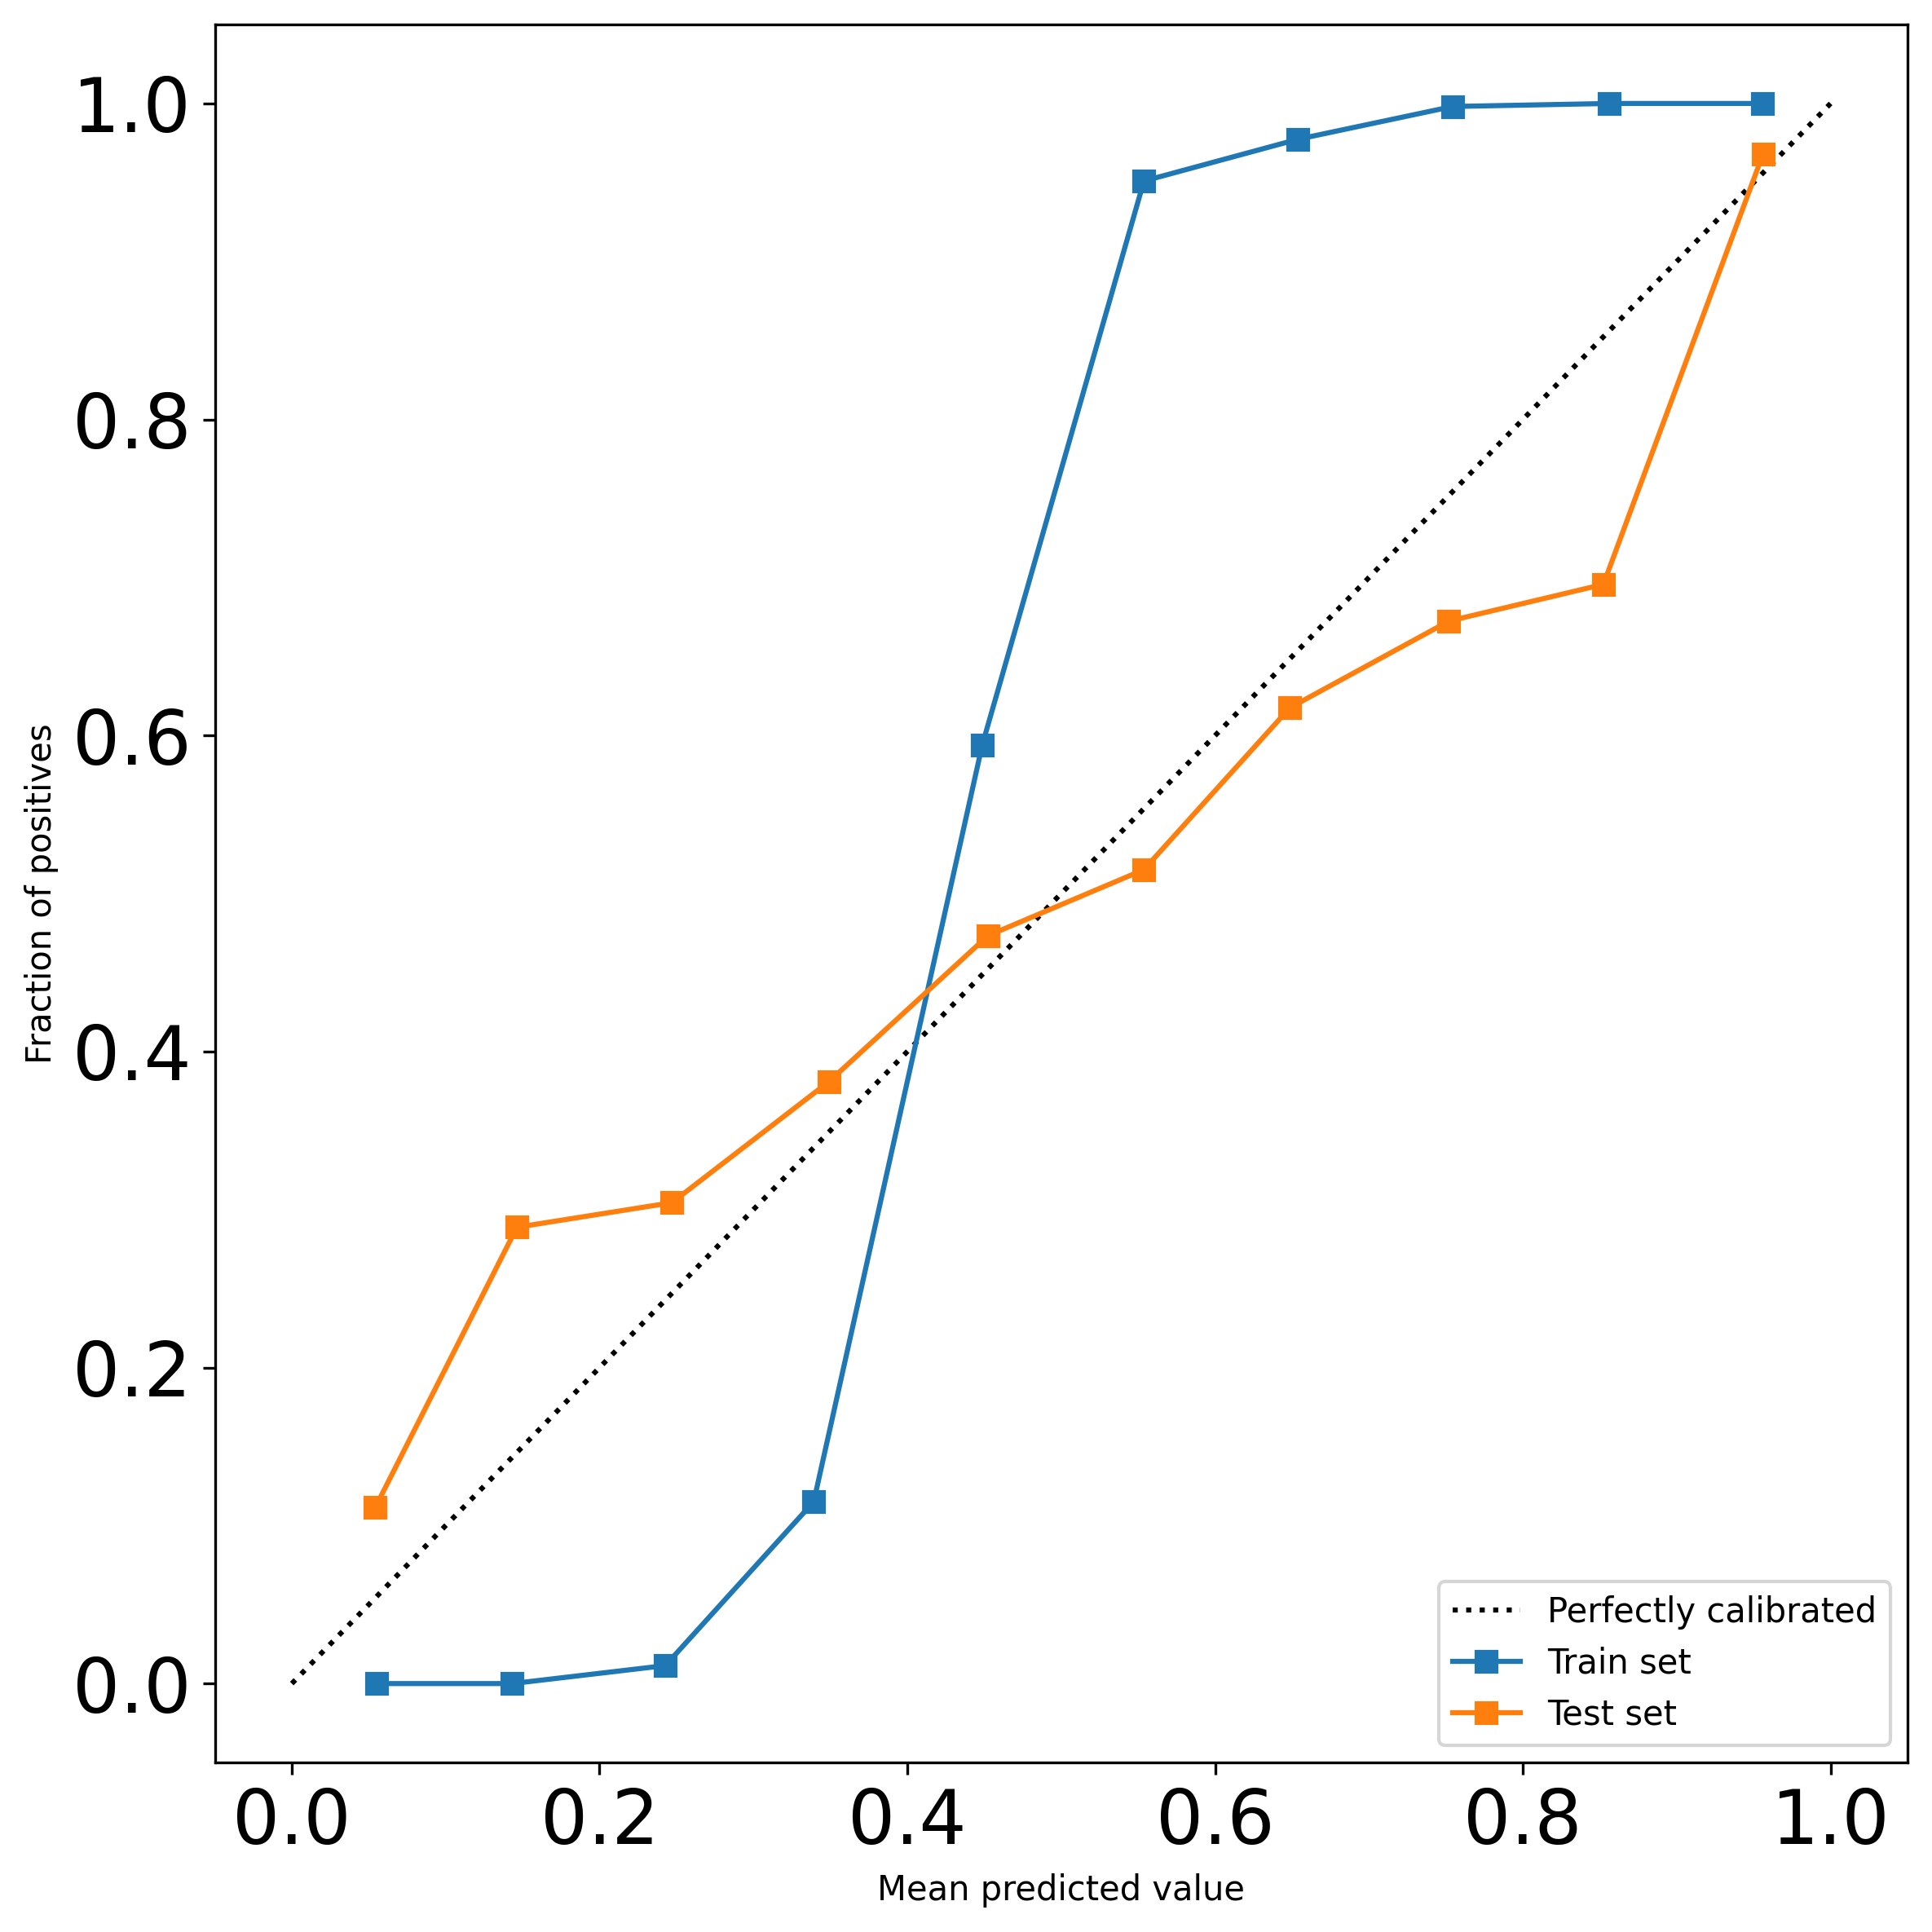

In [21]:
from sklearn.calibration import calibration_curve
def draw_calibration(labels, results,n=5):
    '''
    plot calibration curve
    :param labels:
    :param results:
    :param n:
    :return:
    '''
    
    plt.figure(0)
    plt.figure(dpi=300)
    plt.title("calibration_curve")
    ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=2)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    label = np.array(labels[0])
    result = np.array(results[0])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Train set",))

    label = np.array(labels[1])
    result = np.array(results[1])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Test set",))




    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

plt.figure(dpi=300)
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
draw_calibration([train_y_lists,test_y_lists],[train_pre_lists,test_pre_lists],10)



0.7657074365160998


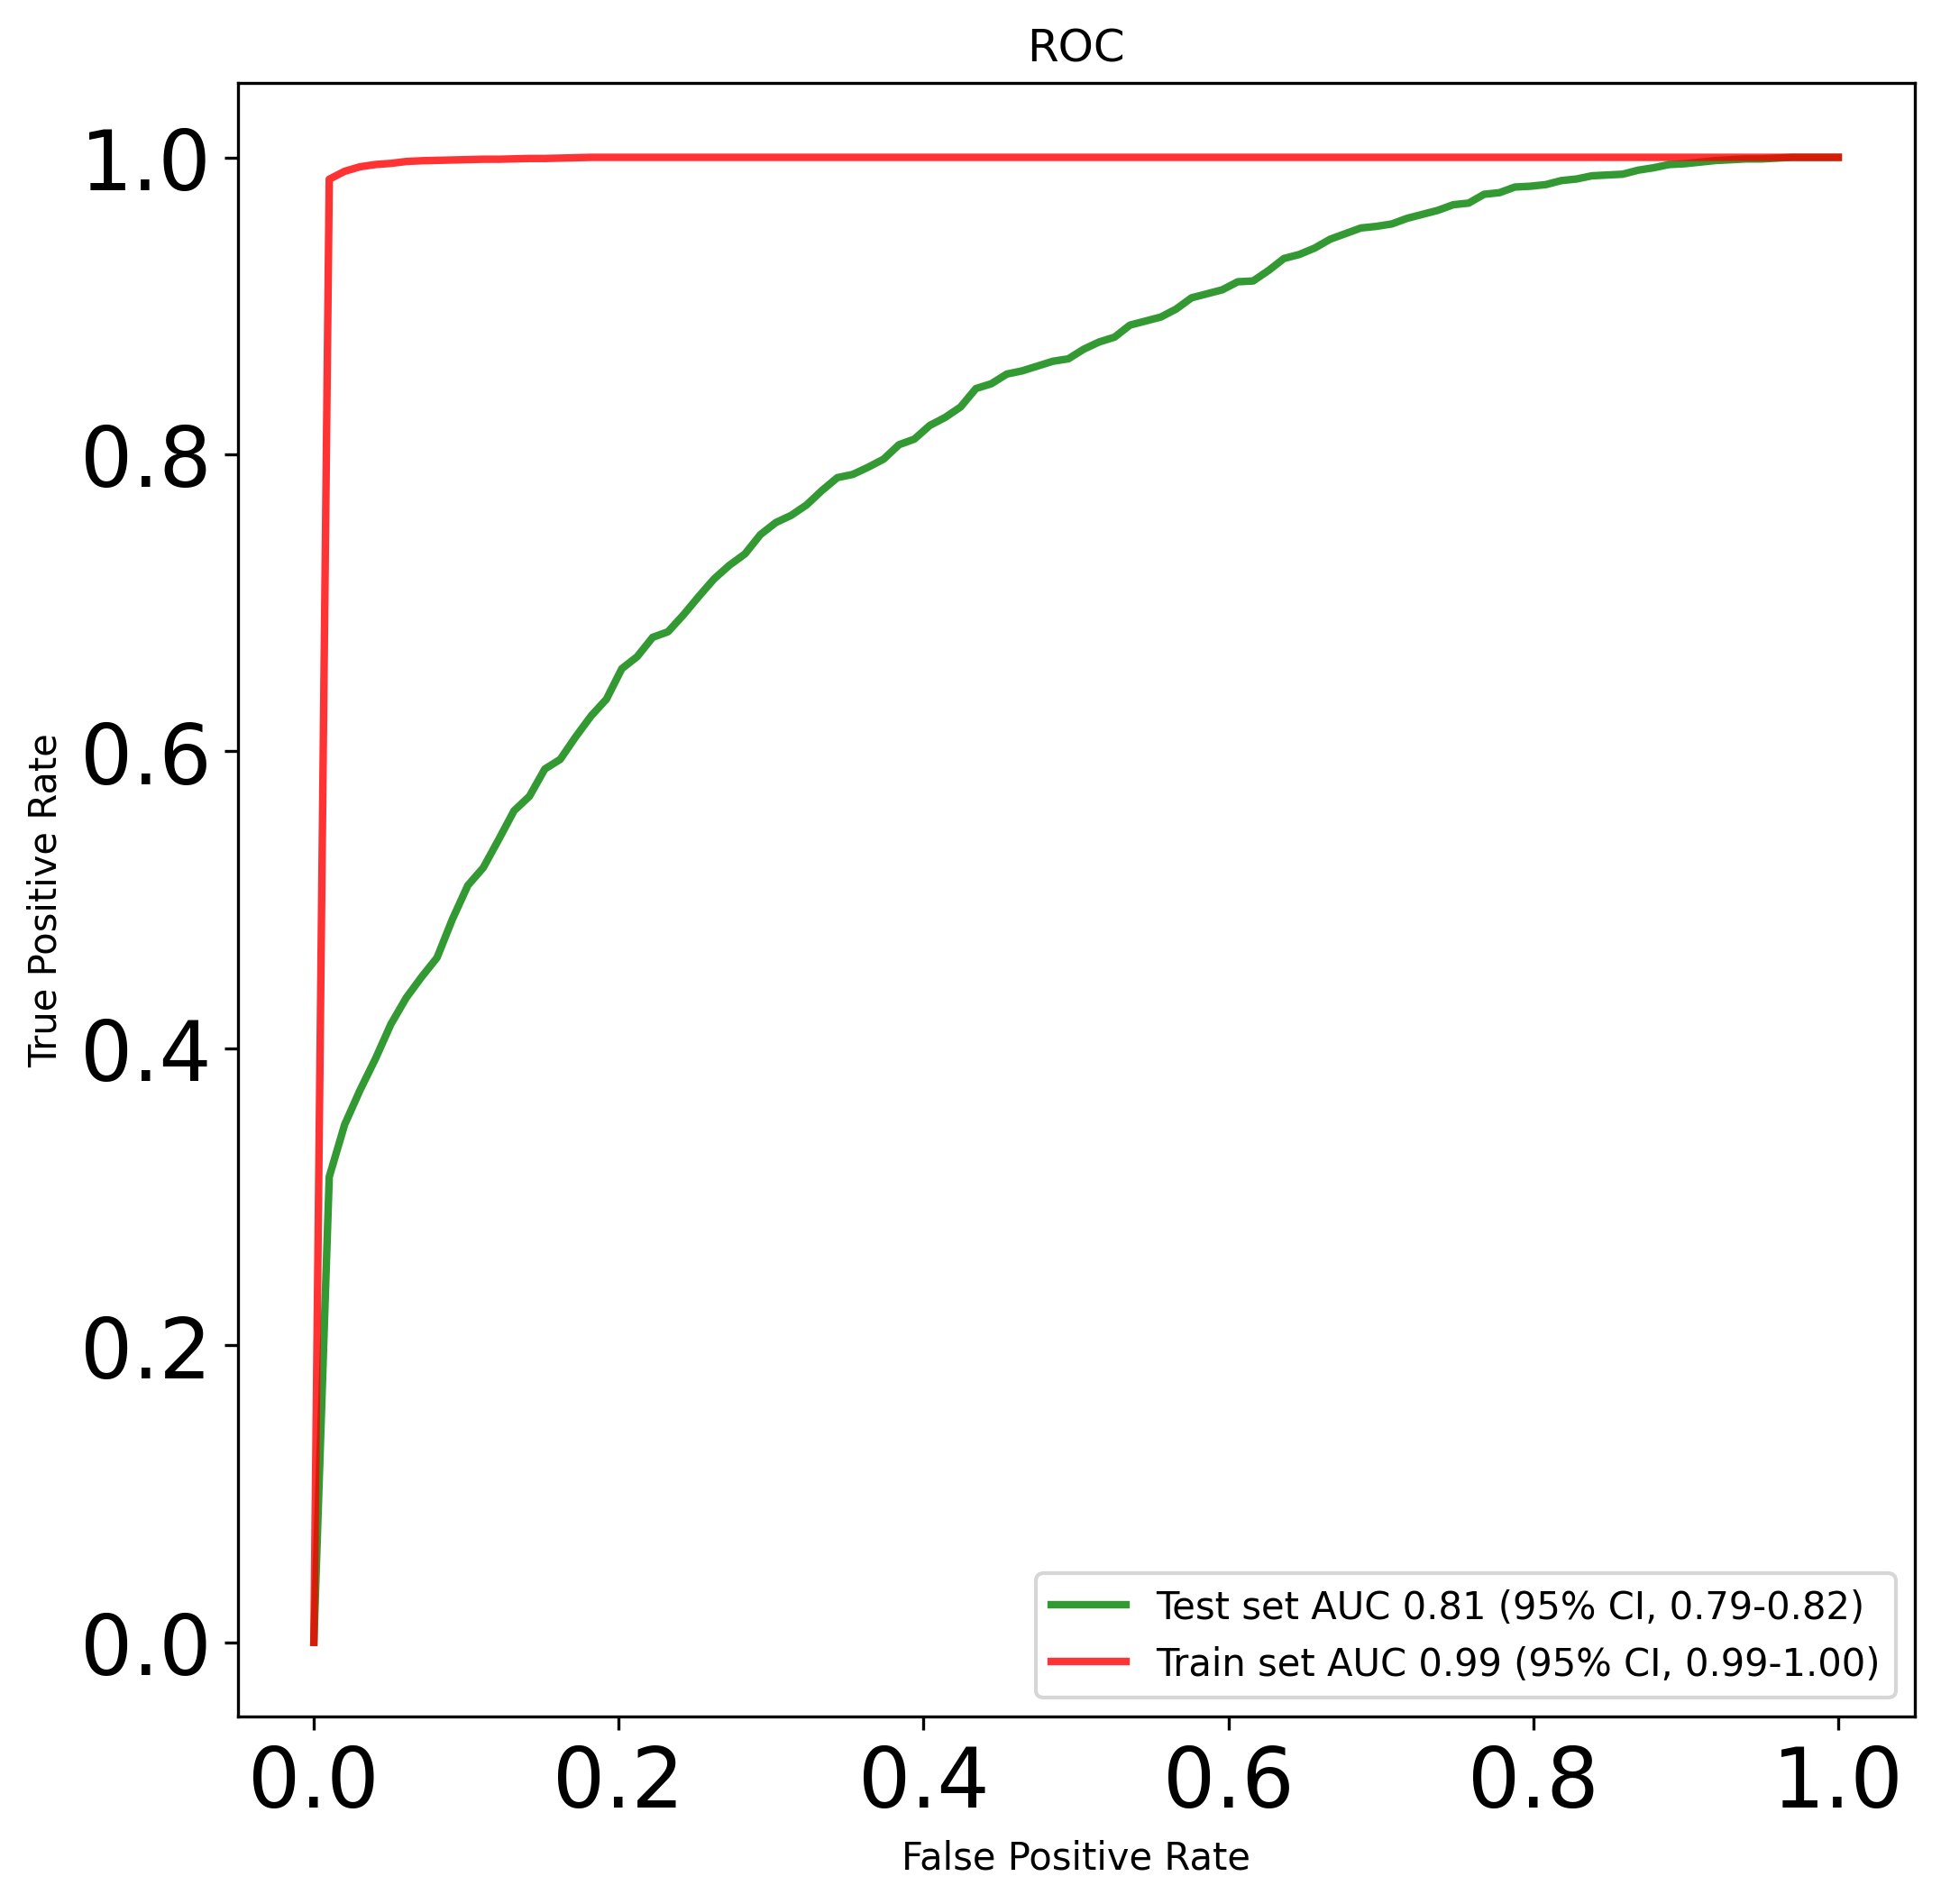

In [22]:
print(np.average(c))
finalpres = pd.DataFrame(bigtestresults)
finaltask = []
lss = []
for i in finalpres.columns:
    temp1 = finalpres.iloc[:, i].value_counts().index[0]
    lss.append(temp1)

mean_test_tpr=np.mean(test_tprs,axis=0)
mean_test_tpr[-1]=1.0
mean_test_auc=auc(mean_fpr,mean_test_tpr)
aucs=[]

for test_tpr in test_tprs:
    auc_=auc(mean_fpr,test_tpr)
    aucs.append(auc_)


'''
    计算置区间
'''
std_test_auc=np.std(aucs,axis=0)

low_=mean_test_auc-1.96*std_test_auc
upper=mean_test_auc+1.96*std_test_auc
plt.figure(dpi=300)
plt.plot(mean_fpr,mean_test_tpr,color='g',label=r'Test set AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_test_auc,low_,upper),lw=2,alpha=0.8)


mean_train_tpr=np.mean(train_tprs,axis=0)
mean_train_tpr[-1]=1.0
mean_train_auc=auc(mean_fpr,mean_train_tpr)
aucs = []
for tpr in train_tprs:
    auc_ = auc(mean_fpr, tpr)
    aucs.append(auc_)

std_train_auc = np.std(aucs, axis=0)
low_=mean_train_auc-1.96*std_train_auc
upper=mean_train_auc+1.96*std_train_auc
plt.plot(mean_fpr,mean_train_tpr,color='r',label='Train set AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_train_auc,low_,upper),lw=2,alpha=0.8)



#std_train_tpr=np.std(train_tprs,axis=0)
#train_tprs_upper=np.minimum(mean_train_tpr+std_train_tpr,1)
#train_tprs_lower=np.maximum(mean_train_tpr-std_train_tpr,0)
#plt.fill_between(mean_train_tpr,train_tprs_lower,train_tprs_upper,color='b',alpha=.2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()


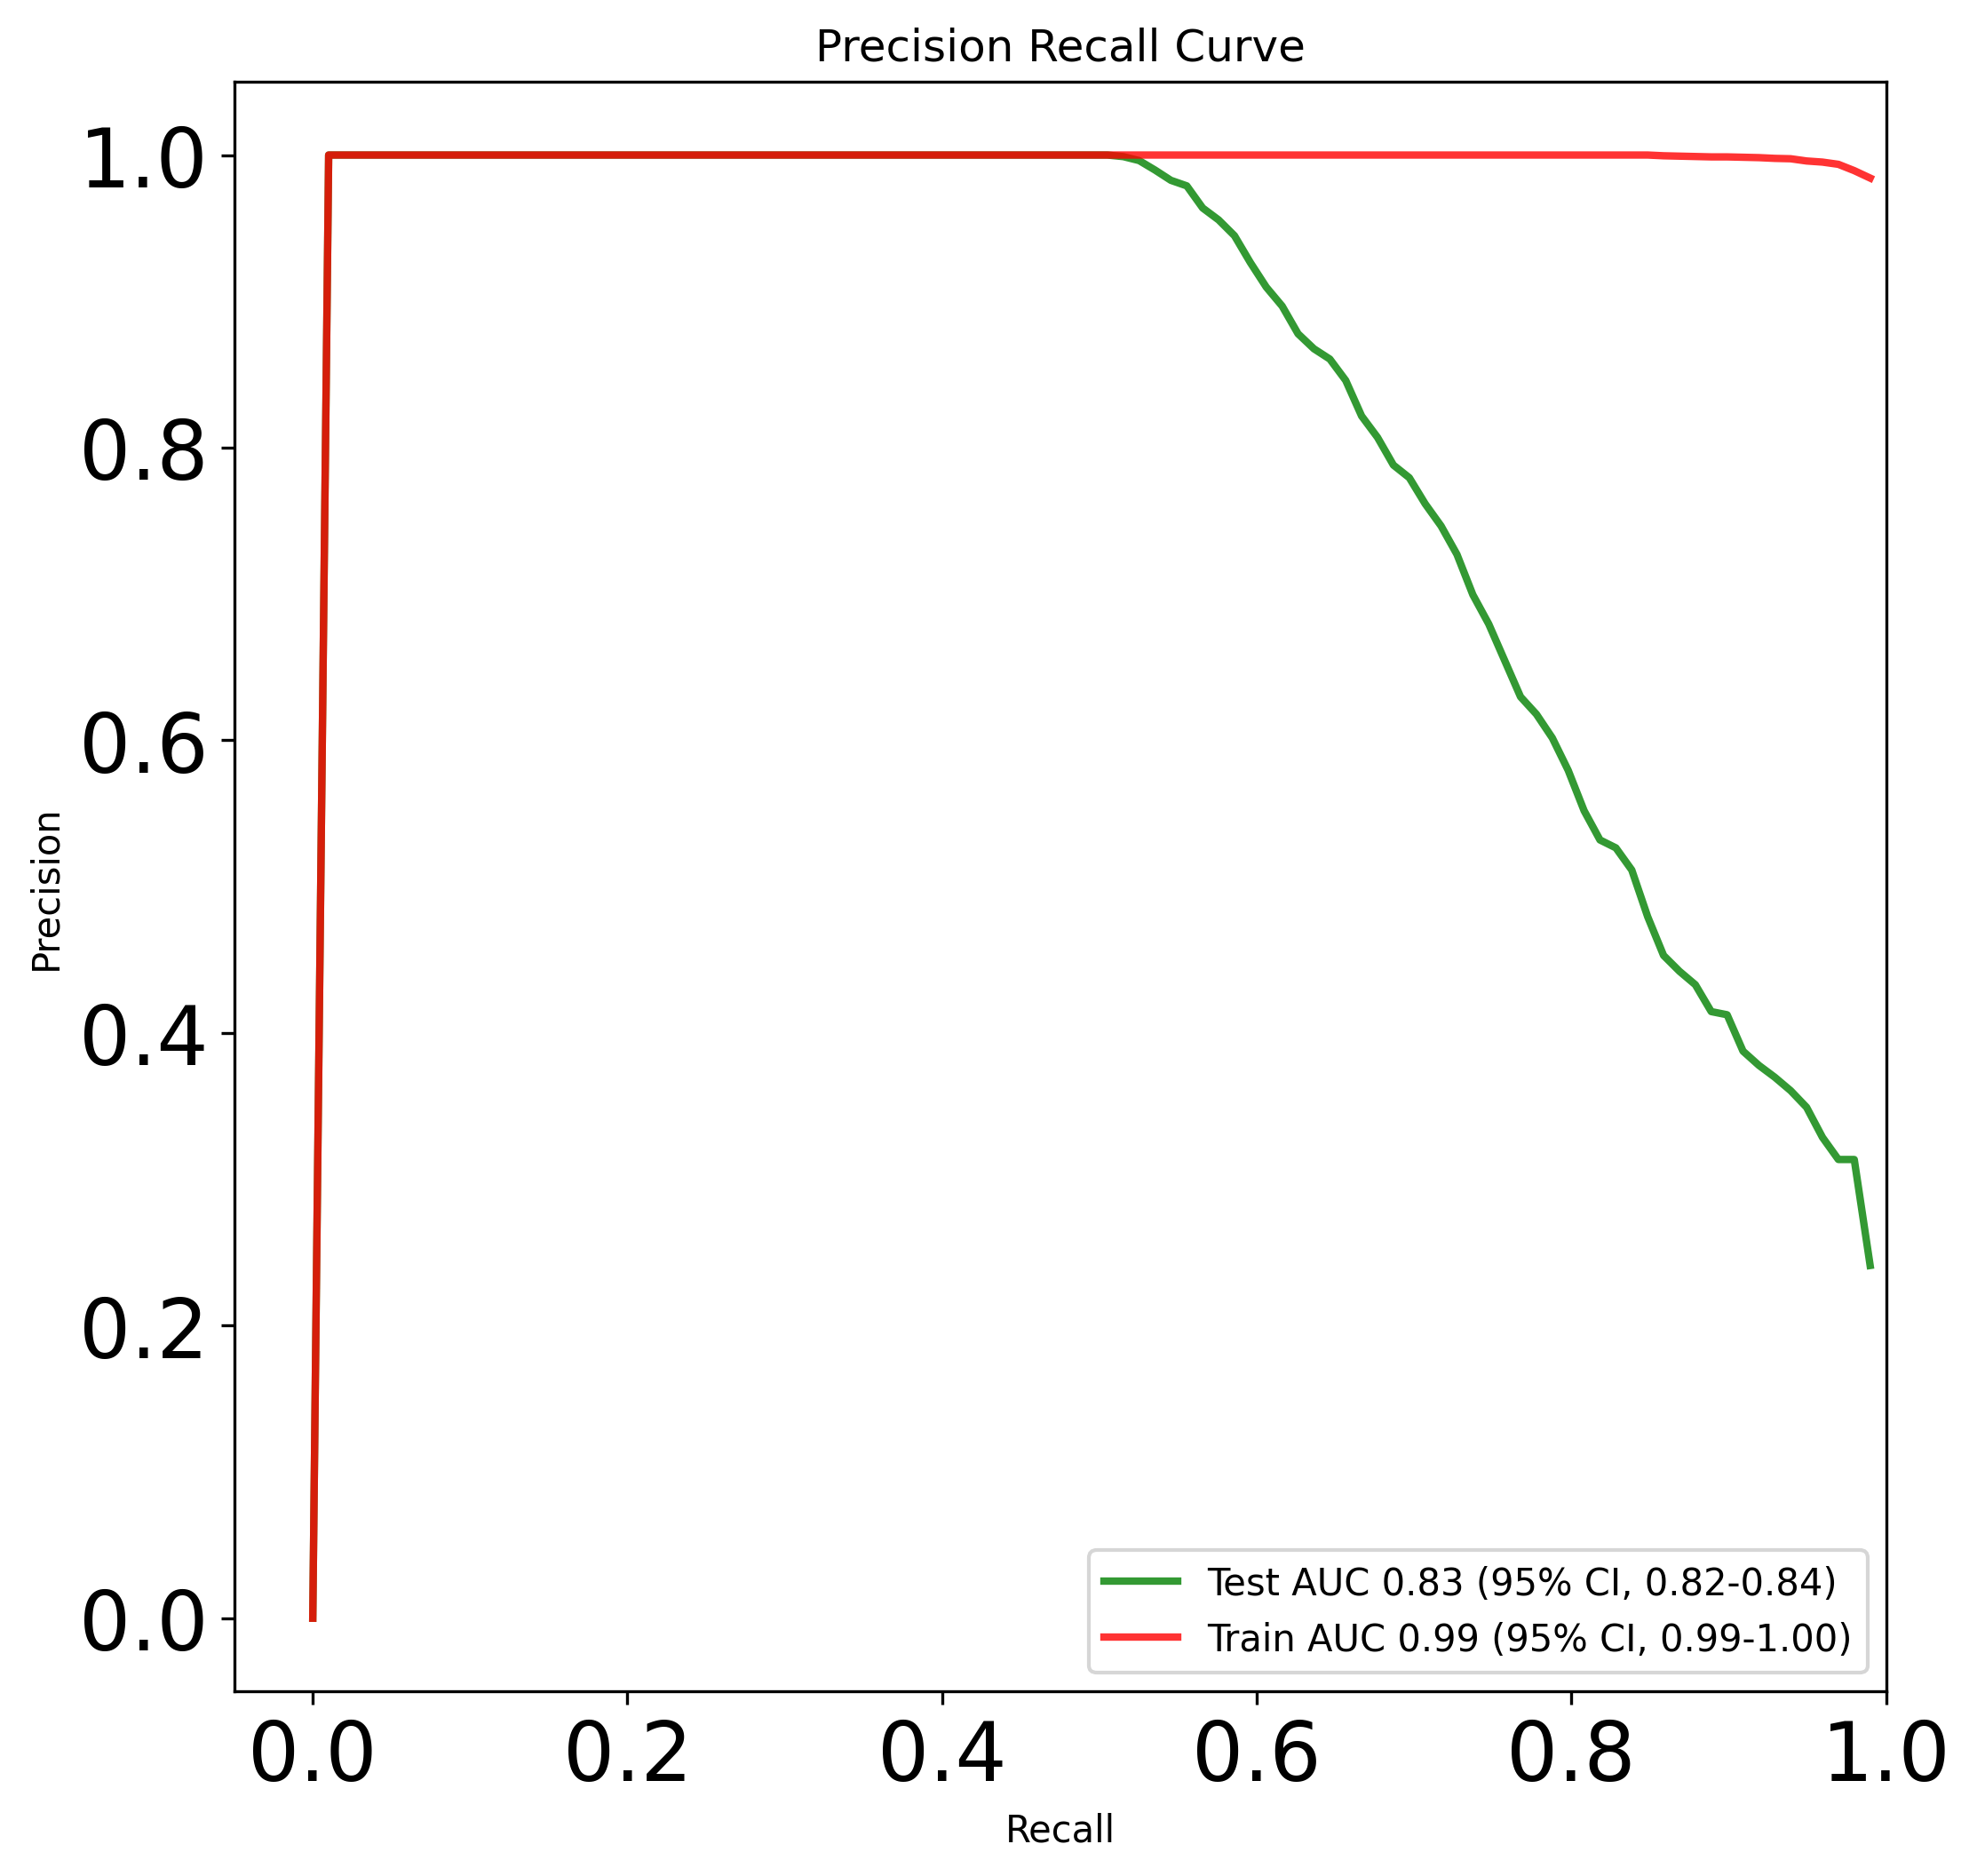

In [23]:
#Plot PR ROC


mean_test_precision=np.mean(test_precisions,axis=0)
mean_test_precision[-1]=1.0
mean_test_auc=auc(mean_recall,mean_test_precision)
aucs=[]

for test_precision in test_precisions:
    auc_=auc(mean_recall,test_precision)
    aucs.append(auc_)


'''
    计算置区间
'''
std_test_auc=np.std(aucs,axis=0)

low_=mean_test_auc-1.96*std_test_auc
upper=mean_test_auc+1.96*std_test_auc
plt.figure(dpi=300)
plt.plot(mean_recall[:-1],mean_test_precision[:-1],color='g',label=r'Test AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_test_auc,low_,upper),lw=2,alpha=0.8)


mean_train_precision=np.mean(train_precisions,axis=0)
mean_train_precision[-1]=1.0
mean_train_auc=auc(mean_recall,mean_train_precision)
aucs = []
for train_precision in train_tprs:
    auc_ = auc(mean_recall, train_precision)
    aucs.append(auc_)

std_train_auc = np.std(aucs, axis=0)
low_=mean_train_auc-1.96*std_train_auc
upper=mean_train_auc+1.96*std_train_auc
plt.plot(mean_recall[:-1],mean_train_precision[:-1],color='r',label='Train AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_train_auc,low_,upper),lw=2,alpha=0.8)



#std_train_tpr=np.std(train_tprs,axis=0)
#train_tprs_upper=np.minimum(mean_train_tpr+std_train_tpr,1)
#train_tprs_lower=np.maximum(mean_train_tpr-std_train_tpr,0)
#plt.fill_between(mean_train_tpr,train_tprs_lower,train_tprs_upper,color='b',alpha=.2)

plt.xlim([-0.05, 1.00])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()


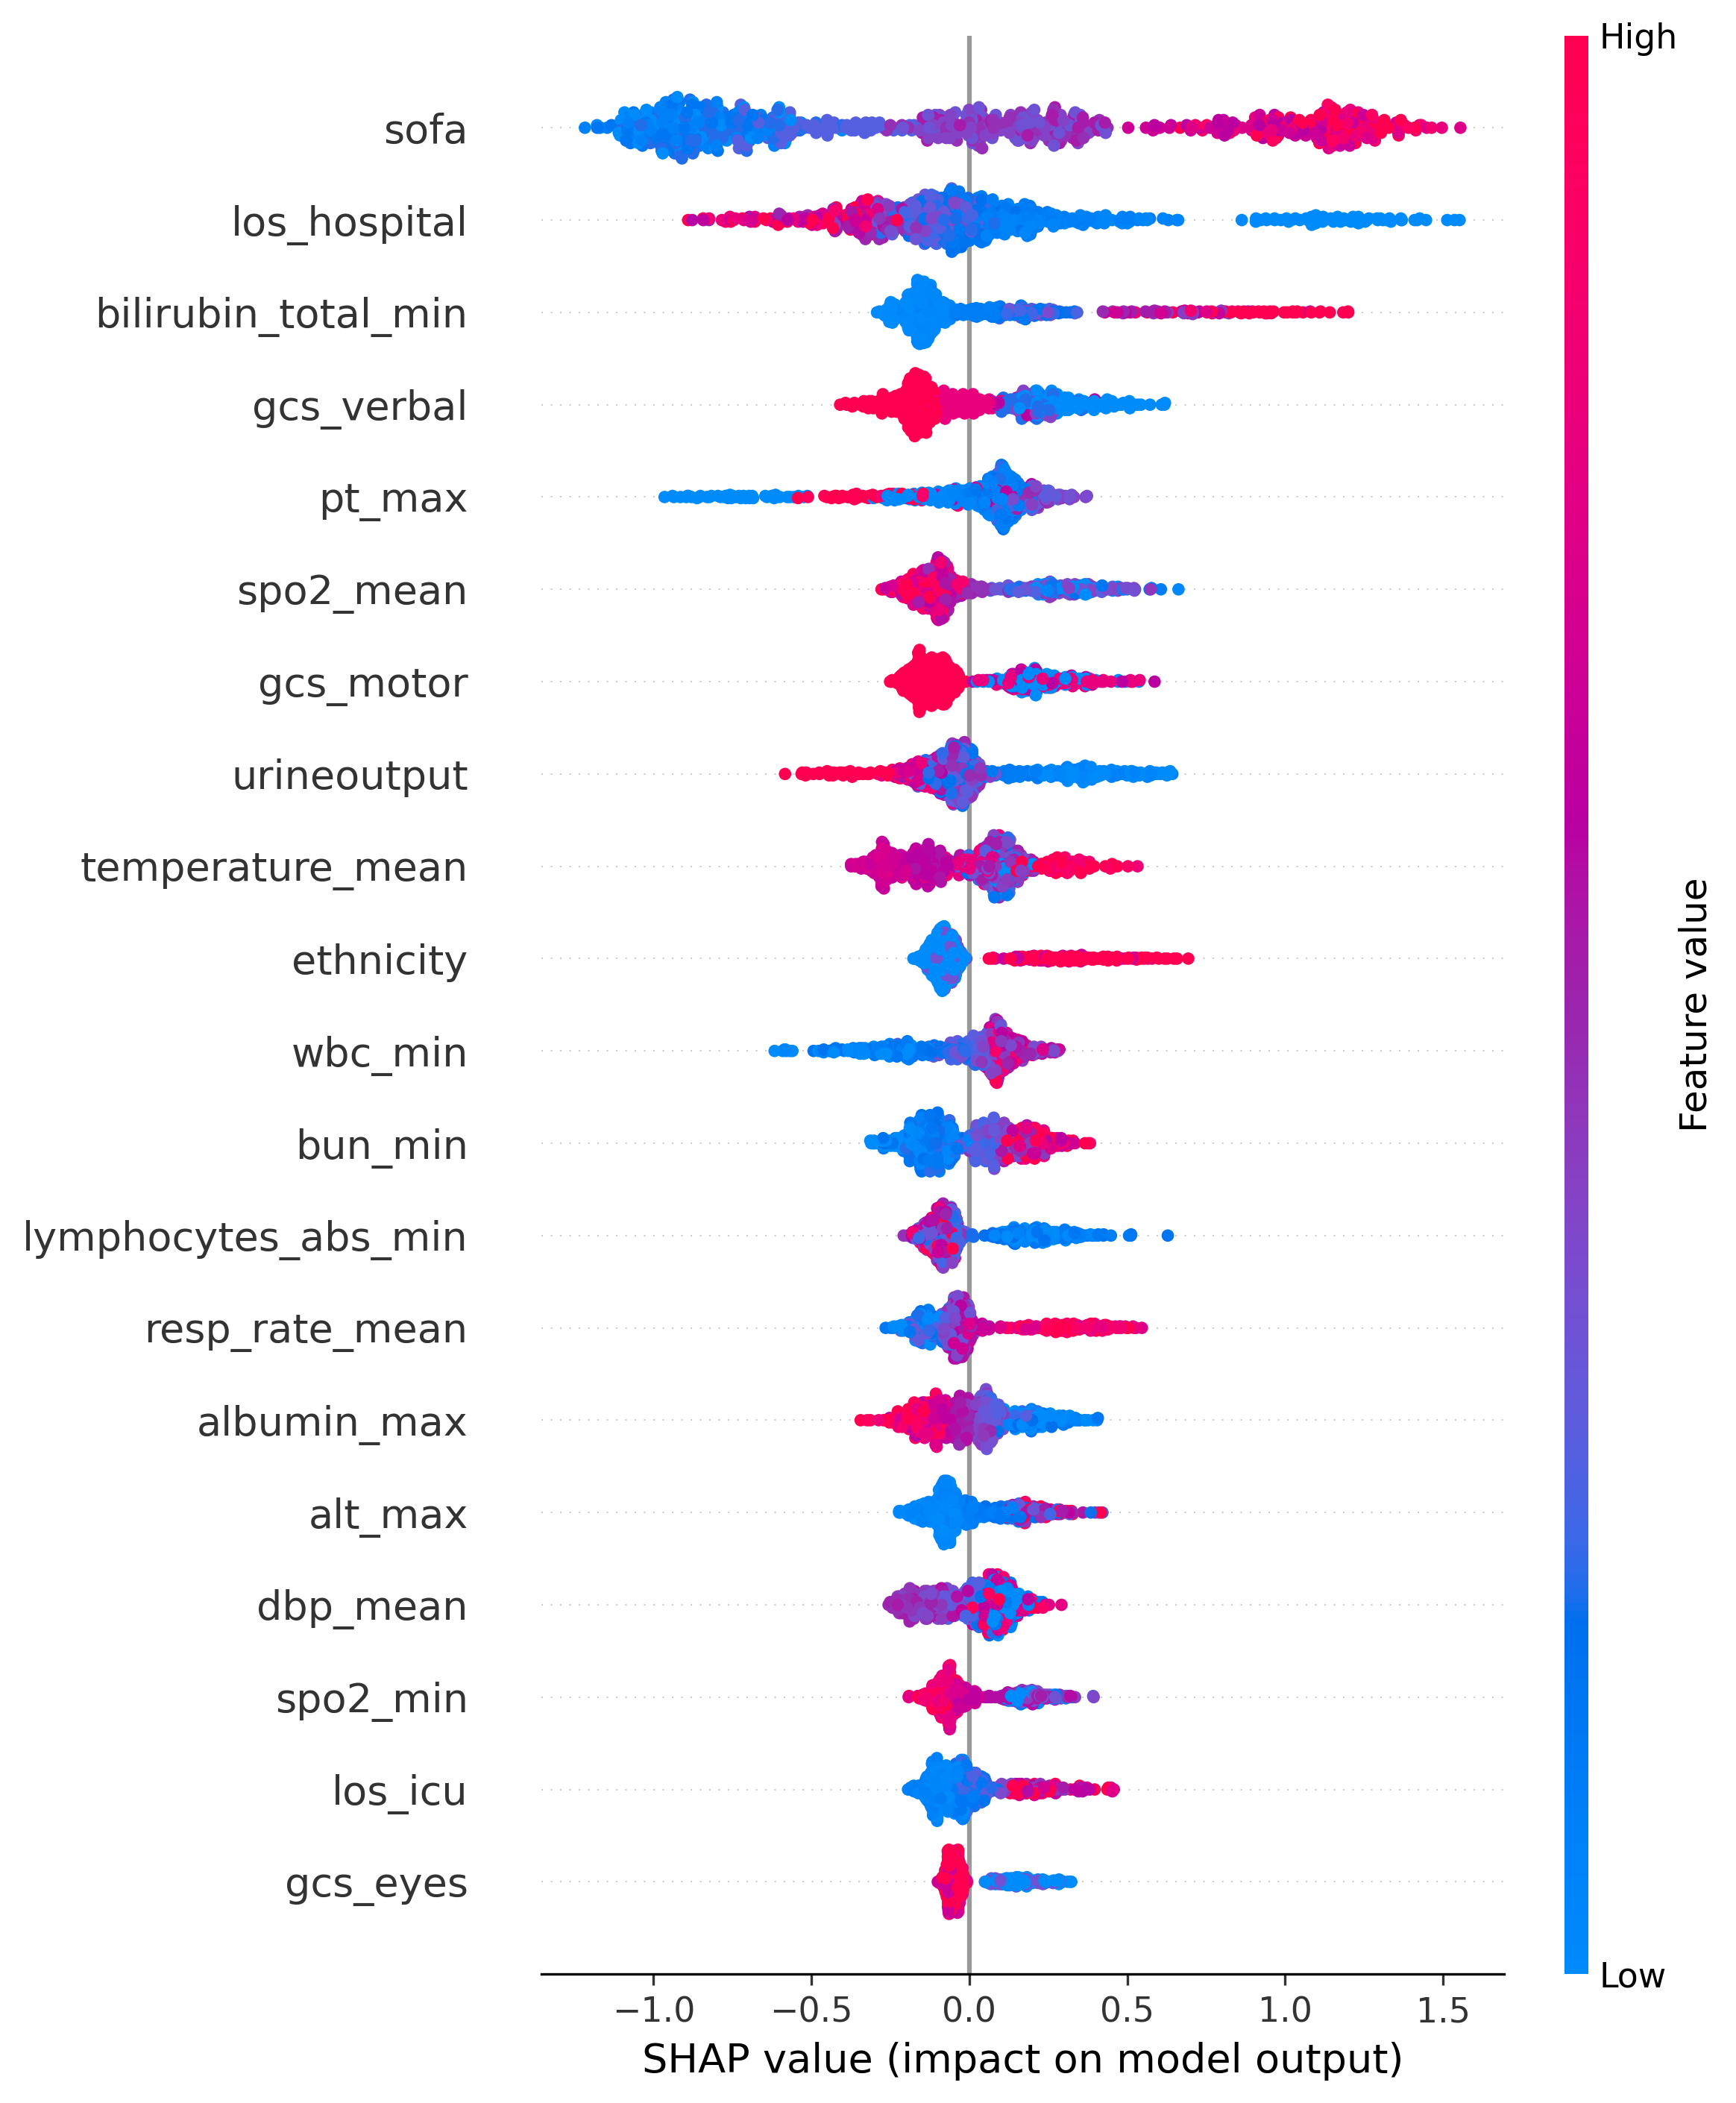

In [24]:
shap.initjs()
plt.figure(figsize=(16,18),dpi = 300)
shap.summary_plot(shap_values[1], train_x)

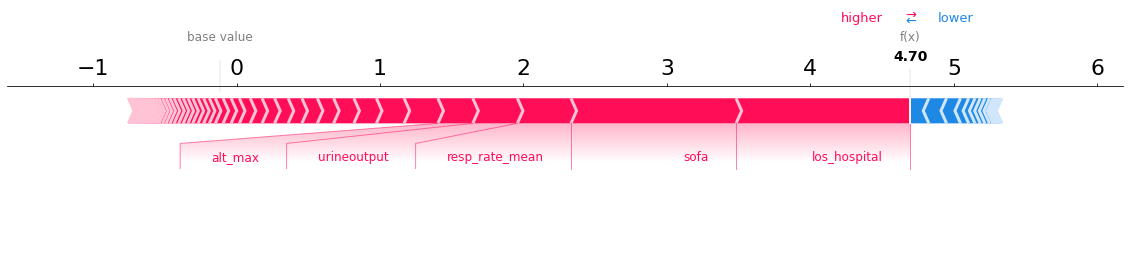

In [25]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][17],features,matplotlib= True)

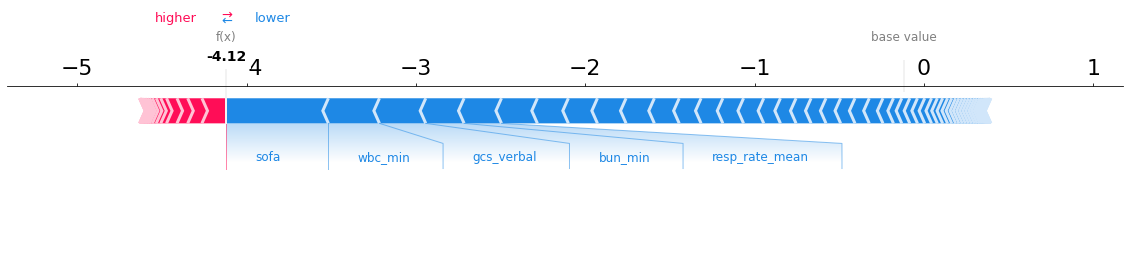

In [26]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][9],features,matplotlib= True)